In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.2
seed 3
2023-08-20 19:11:10.618569


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-9.0191)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(3.3334)
penalty_target_min tensor(-11.5483) penalty_target_max tensor(7.4629)
train_loss:  -8.111957794976234
valid_loss:  -8.256244630432128
h_min_tilde -11.5483265 ell_tilde -8.140815162067414 kappa_tilde 0.00027086403892074445


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 3.8927955627441406

 2 7.036490201950073

 3 7.000061750411987

 4 6.968151092529297

 5 3.9652907848358154

 6 3.25468111038208

 7 3.4917681217193604

 8 3.3132927417755127

 9 3.4236812591552734

 10 3.376551389694214

 11 3.4174816608428955

 12 3.3317105770111084

 13 3.2834668159484863

 14 6.880216836929321

 15 4.535571098327637

 16 3.456613540649414

 17 3.425947904586792

 18 3.3857839107513428

 19 3.399752616882324

 20 3.870222806930542

 21 3.524224042892456

 22 3.987957000732422

 23 6.86146092414856

 24 7.456827640533447

 25 3.498809814453125

 26 3.361161231994629

 27 7.274517297744751

 28 7.115221261978149

 29 7.0440027713775635

 30 7.130674362182617

 31 7.262179613113403

 32 5.164049386978149

 33 7.1591339111328125

 34 7.122657060623169

 35 3.5056698322296143

 36 4.260210275650024

 37 3.5726678371429443

 38 3.4925835132598877

 39 3.619168996810913

 40 3.4110195636749268

 41 3.59340500831604

 42 3.611337184906006

 43 3.6450552940368652

 44 3.

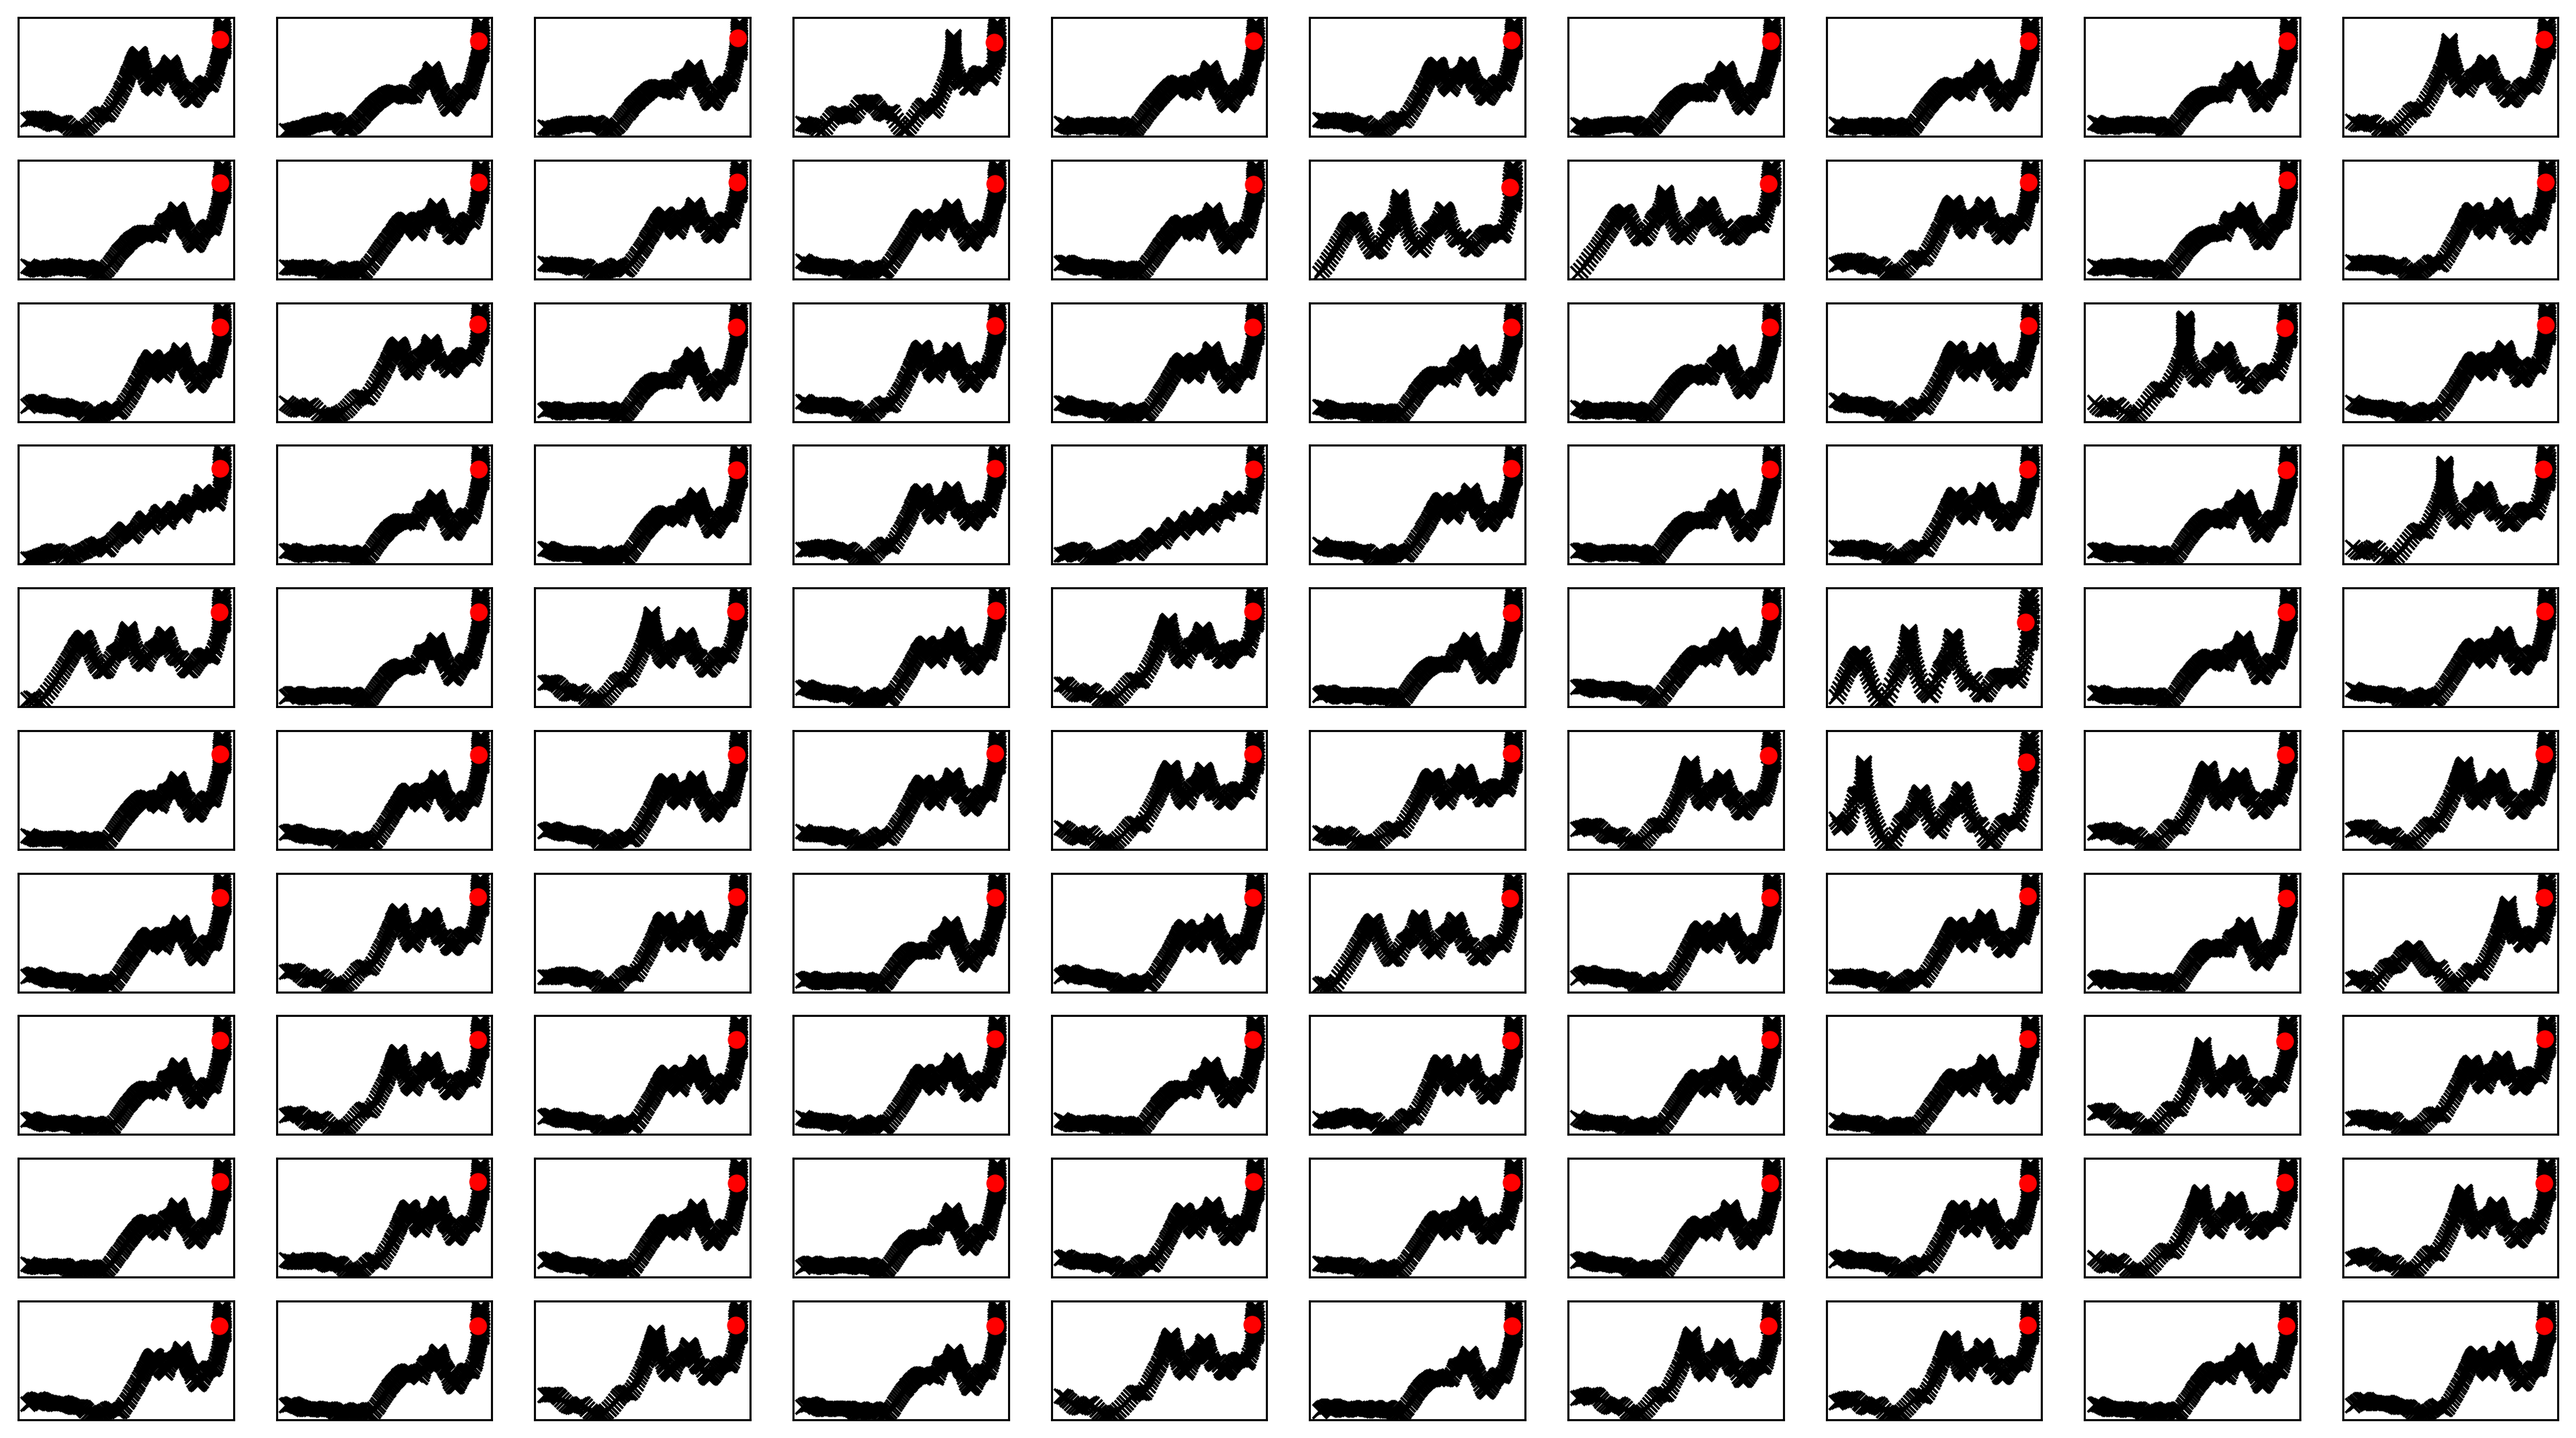

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

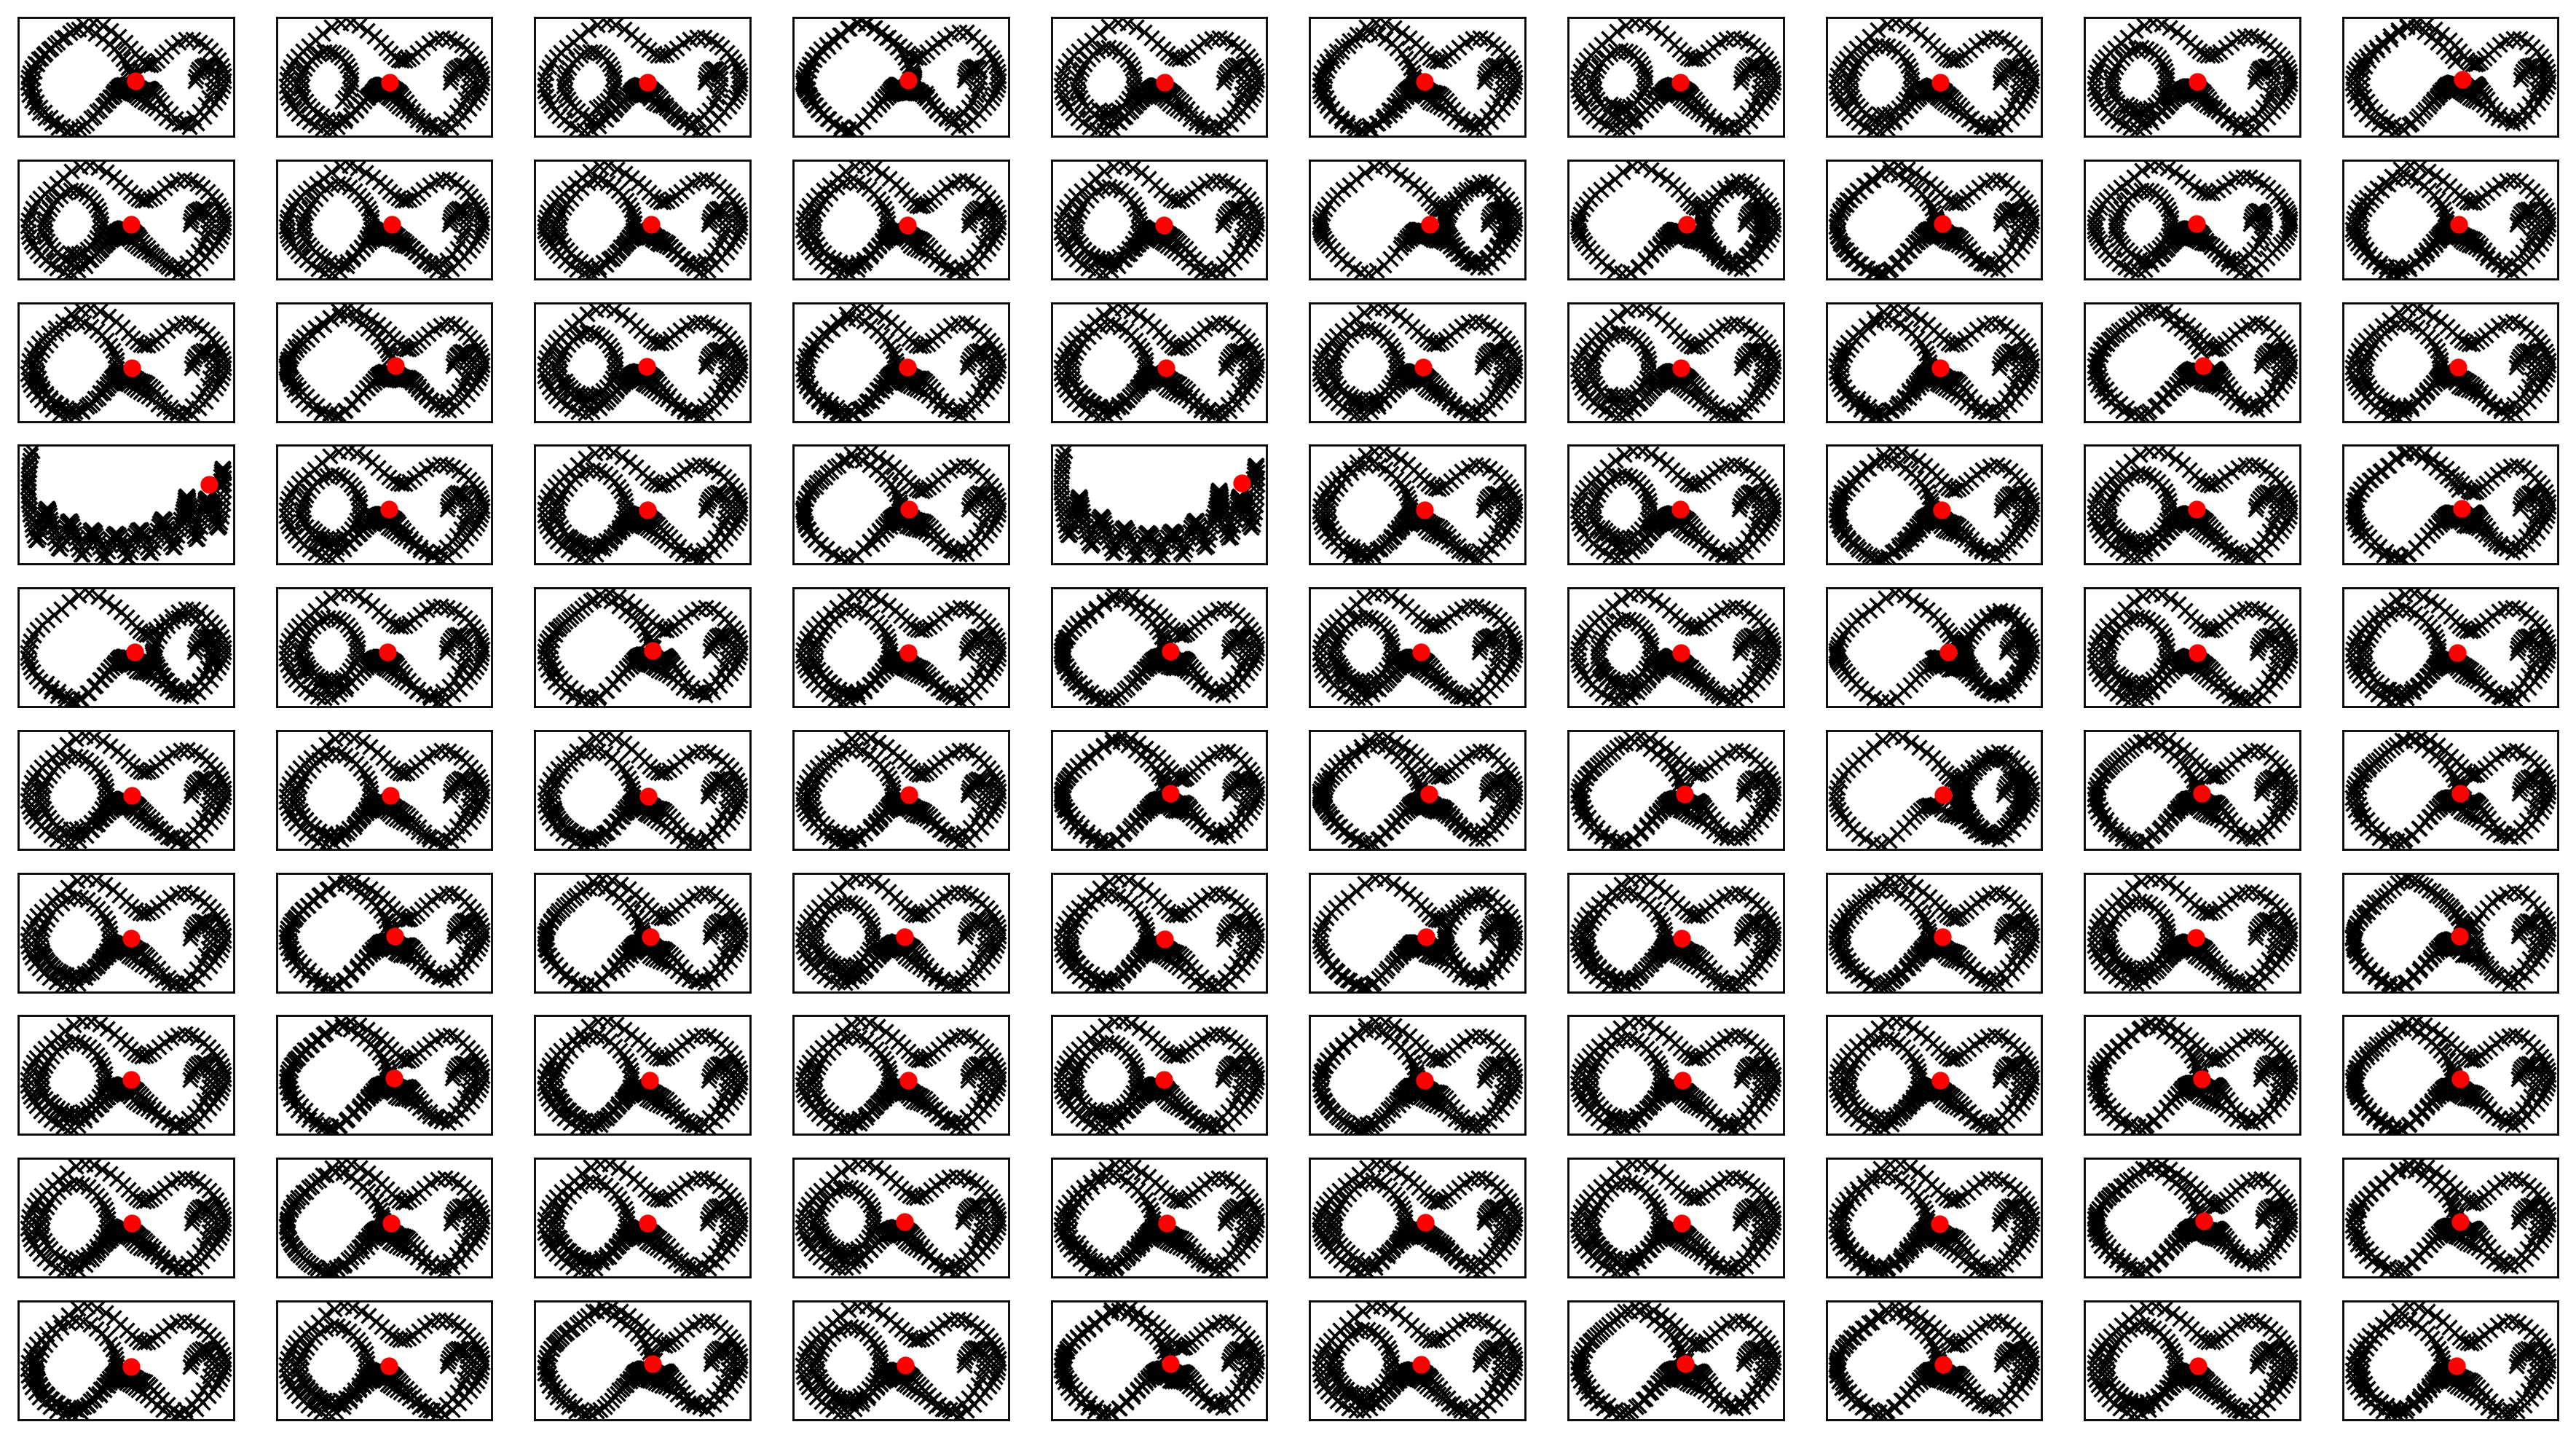

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
# plt.show()
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")

In [8]:
print(datetime.datetime.now())

2023-08-20 19:19:42.146905


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2
predict diverge [  7.5492634  -53.37138189  34.31025698 -27.11743798] [ -0.1559654  -48.83528252  -1.44517496   1.65955365] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 129

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16
predict diverge [  1.51105592 -20.39534718  24.27899159 403.26138674] [-1.05747322e+00 -2.95014130e-01  5.30291041e-02  3.94851908e+02] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 188

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.37925  validloss 1.43411±0.00000  bestvalidloss 1.43411  last_update 0
train: iter 1  trainloss 1.26482  validloss 1.32424±0.00000  bestvalidloss 1.32424  last_update 0
train: iter 2  trainloss 1.14453  validloss 1.16710±0.00000  bestvalidloss 1.16710  last_update 0
train: iter 3  trainloss 1.06609  validloss 1.06110±0.00000  bestvalidloss 1.06110  last_update 0
train: iter 4  trainloss 1.00572  validloss 0.99284±0.00000  bestvalidloss 0.99284  last_update 0
train: iter 5  trainloss 0.96527  validloss 0.93888±0.00000  bestvalidloss 0.93888  last_update 0
train: iter 6  trainloss 0.92545  validloss 0.89449±0.00000  bestvalidloss 0.89449  last_update 0
train: iter 7  trainloss 0.88720  validloss 0.85686±0.00000  bestvalidloss 0.85686  last_update 0
train: iter 8  trainloss 0.84902  validloss 0.81797±0.00000  bestvalidloss 0.81797  last_update 0
train: iter 9  trainloss 0.81444  validloss 0.78548±0.00000  bestvalidloss 0.78548  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.41846  validloss 0.43634±0.00000  bestvalidloss 0.42785  last_update 4
train: iter 84  trainloss 0.40459  validloss 0.42121±0.00000  bestvalidloss 0.42121  last_update 0
train: iter 85  trainloss 0.41164  validloss 0.43410±0.00000  bestvalidloss 0.42121  last_update 1
train: iter 86  trainloss 0.41006  validloss 0.43269±0.00000  bestvalidloss 0.42121  last_update 2
train: iter 87  trainloss 0.40639  validloss 0.46193±0.00000  bestvalidloss 0.42121  last_update 3
train: iter 88  trainloss 0.40294  validloss 0.43327±0.00000  bestvalidloss 0.42121  last_update 4
train: iter 89  trainloss 0.40587  validloss 0.42024±0.00000  bestvalidloss 0.42024  last_update 0
train: iter 90  trainloss 0.40260  validloss 0.42067±0.00000  bestvalidloss 0.42024  last_update 1
train: iter 91  trainloss 0.40044  validloss 0.41582±0.00000  bestvalidloss 0.41582  last_update 0
train: iter 92  trainloss 0.40105  validloss 0.43534±0.00000  bestvalidloss 0.41582  last_update 1
train: ite

train: iter 166  trainloss 0.33672  validloss 0.39395±0.00000  bestvalidloss 0.38830  last_update 19
train: iter 167  trainloss 0.34503  validloss 0.40912±0.00000  bestvalidloss 0.38830  last_update 20
train: iter 168  trainloss 0.34173  validloss 0.39425±0.00000  bestvalidloss 0.38830  last_update 21
train: iter 169  trainloss 0.33879  validloss 0.44889±0.00000  bestvalidloss 0.38830  last_update 22
train: iter 170  trainloss 0.34135  validloss 0.40054±0.00000  bestvalidloss 0.38830  last_update 23
train: iter 171  trainloss 0.33683  validloss 0.39585±0.00000  bestvalidloss 0.38830  last_update 24
train: iter 172  trainloss 0.33412  validloss 0.39181±0.00000  bestvalidloss 0.38830  last_update 25
train: iter 173  trainloss 0.33848  validloss 0.39190±0.00000  bestvalidloss 0.38830  last_update 26
train: iter 174  trainloss 0.33352  validloss 0.39277±0.00000  bestvalidloss 0.38830  last_update 27
train: iter 175  trainloss 0.34242  validloss 0.42822±0.00000  bestvalidloss 0.38830  last_

train: iter 248  trainloss 0.31420  validloss 0.44842±0.00000  bestvalidloss 0.37040  last_update 6
train: iter 249  trainloss 0.30737  validloss 0.38132±0.00000  bestvalidloss 0.37040  last_update 7
train: iter 250  trainloss 0.31233  validloss 0.37332±0.00000  bestvalidloss 0.37040  last_update 8
train: iter 251  trainloss 0.31340  validloss 0.36784±0.00000  bestvalidloss 0.36784  last_update 0
train: iter 252  trainloss 0.31249  validloss 0.37671±0.00000  bestvalidloss 0.36784  last_update 1
train: iter 253  trainloss 0.31045  validloss 0.39503±0.00000  bestvalidloss 0.36784  last_update 2
train: iter 254  trainloss 0.31396  validloss 0.38902±0.00000  bestvalidloss 0.36784  last_update 3
train: iter 255  trainloss 0.30706  validloss 0.40773±0.00000  bestvalidloss 0.36784  last_update 4
train: iter 256  trainloss 0.31036  validloss 0.40083±0.00000  bestvalidloss 0.36784  last_update 5
train: iter 257  trainloss 0.30828  validloss 0.37821±0.00000  bestvalidloss 0.36784  last_update 6


train: iter 330  trainloss 0.29102  validloss 0.37167±0.00000  bestvalidloss 0.35597  last_update 11
train: iter 331  trainloss 0.30270  validloss 0.38468±0.00000  bestvalidloss 0.35597  last_update 12
train: iter 332  trainloss 0.29922  validloss 0.36553±0.00000  bestvalidloss 0.35597  last_update 13
train: iter 333  trainloss 0.28972  validloss 0.37373±0.00000  bestvalidloss 0.35597  last_update 14
train: iter 334  trainloss 0.29497  validloss 0.37238±0.00000  bestvalidloss 0.35597  last_update 15
train: iter 335  trainloss 0.29575  validloss 0.37778±0.00000  bestvalidloss 0.35597  last_update 16
train: iter 336  trainloss 0.29544  validloss 0.35914±0.00000  bestvalidloss 0.35597  last_update 17
train: iter 337  trainloss 0.29311  validloss 0.36737±0.00000  bestvalidloss 0.35597  last_update 18
train: iter 338  trainloss 0.28892  validloss 0.38069±0.00000  bestvalidloss 0.35597  last_update 19
train: iter 339  trainloss 0.29169  validloss 0.39439±0.00000  bestvalidloss 0.35597  last_

train: iter 412  trainloss 0.28076  validloss 0.37585±0.00000  bestvalidloss 0.34830  last_update 3
train: iter 413  trainloss 0.27591  validloss 0.37675±0.00000  bestvalidloss 0.34830  last_update 4
train: iter 414  trainloss 0.27638  validloss 0.37059±0.00000  bestvalidloss 0.34830  last_update 5
train: iter 415  trainloss 0.27690  validloss 0.38178±0.00000  bestvalidloss 0.34830  last_update 6
train: iter 416  trainloss 0.27675  validloss 0.36173±0.00000  bestvalidloss 0.34830  last_update 7
train: iter 417  trainloss 0.27809  validloss 0.37451±0.00000  bestvalidloss 0.34830  last_update 8
train: iter 418  trainloss 0.27360  validloss 0.35184±0.00000  bestvalidloss 0.34830  last_update 9
train: iter 419  trainloss 0.27489  validloss 0.36590±0.00000  bestvalidloss 0.34830  last_update 10
train: iter 420  trainloss 0.27933  validloss 0.37470±0.00000  bestvalidloss 0.34830  last_update 11
train: iter 421  trainloss 0.27570  validloss 0.37858±0.00000  bestvalidloss 0.34830  last_update 

train: iter 494  trainloss 0.26776  validloss 0.38834±0.00000  bestvalidloss 0.34830  last_update 85
train: iter 495  trainloss 0.26565  validloss 0.37122±0.00000  bestvalidloss 0.34830  last_update 86
train: iter 496  trainloss 0.26678  validloss 0.39576±0.00000  bestvalidloss 0.34830  last_update 87
train: iter 497  trainloss 0.26019  validloss 0.35793±0.00000  bestvalidloss 0.34830  last_update 88
train: iter 498  trainloss 0.26403  validloss 0.36790±0.00000  bestvalidloss 0.34830  last_update 89
train: iter 499  trainloss 0.26377  validloss 0.38234±0.00000  bestvalidloss 0.34830  last_update 90
train: iter 500  trainloss 0.26572  validloss 0.38367±0.00000  bestvalidloss 0.34830  last_update 91
train: iter 501  trainloss 0.26482  validloss 0.37499±0.00000  bestvalidloss 0.34830  last_update 92
train: iter 502  trainloss 0.26292  validloss 0.39062±0.00000  bestvalidloss 0.34830  last_update 93
train: iter 503  trainloss 0.26538  validloss 0.36639±0.00000  bestvalidloss 0.34830  last_

train_loss:  -2.10243911664784
valid_loss:  -3.7220692566871647
weight_alpha 1.0 h_min_tilde -11.5483265 ell_tilde -2.426365144655705 kappa_tilde 0.00016554874412954786
train_loss:  -2.5825482797145844
valid_loss:  -2.7619920509338387
weight_alpha 0.2 h_min_tilde -11.5483265 ell_tilde -2.6184370339584353 kappa_tilde 0.00016731965595434968


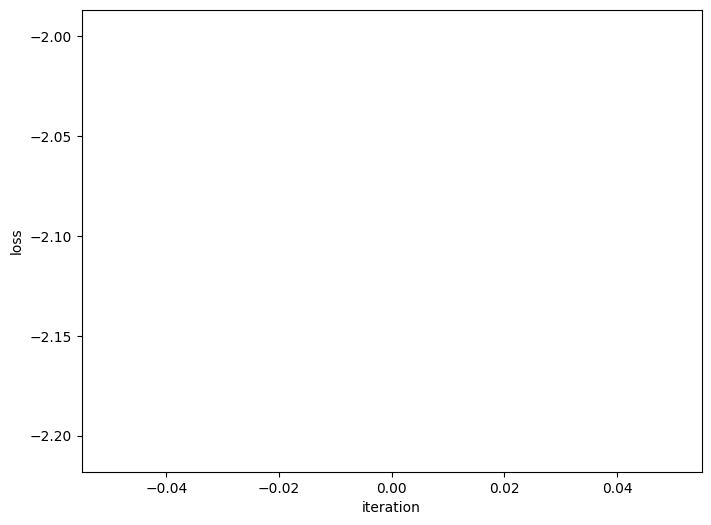

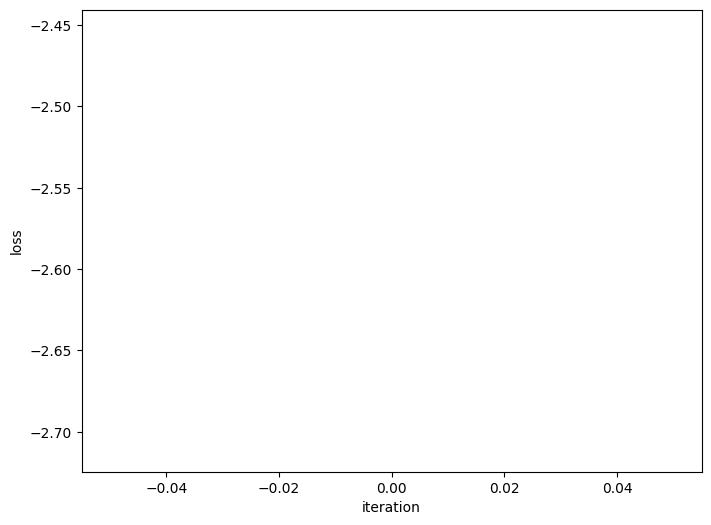

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -508.77294  validloss -552.98807±0.00000  bestvalidloss -552.98807  last_update 0
train: iter 1  trainloss -508.90895  validloss -547.02244±0.00000  bestvalidloss -552.98807  last_update 1
train: iter 2  trainloss -516.76408  validloss -537.02612±0.00000  bestvalidloss -552.98807  last_update 2
train: iter 3  trainloss -503.24921  validloss -532.00914±0.00000  bestvalidloss -552.98807  last_update 3
train: iter 4  trainloss -514.78648  validloss -524.40290±0.00000  bestvalidloss -552.98807  last_update 4
train: iter 5  trainloss -518.45495  validloss -555.51821±0.00000  bestvalidloss -555.51821  last_update 0
train: iter 6  trainloss -517.94569  validloss -544.32888±0.00000  bestvalidloss -555.51821  last_update 1
train: iter 7  trainloss -513.44877  validloss -523.56839±0.00000  bestvalidloss -555.51821  last_update 2
train: iter 8  trainloss -530.58294  validloss -573.80456±0.00000  bestvalidloss -573.80456  last_u

train: iter 76  trainloss -686.91916  validloss -647.72496±0.00000  bestvalidloss -765.77825  last_update 7
train: iter 77  trainloss -663.58183  validloss -631.86542±0.00000  bestvalidloss -765.77825  last_update 8
train: iter 78  trainloss -684.32007  validloss -646.85985±0.00000  bestvalidloss -765.77825  last_update 9
train: iter 79  trainloss -686.07910  validloss -652.04471±0.00000  bestvalidloss -765.77825  last_update 10
train: iter 80  trainloss -696.56745  validloss -631.06443±0.00000  bestvalidloss -765.77825  last_update 11
train: iter 81  trainloss -670.41584  validloss -646.04152±0.00000  bestvalidloss -765.77825  last_update 12
train: iter 82  trainloss -691.94079  validloss -701.10872±0.00000  bestvalidloss -765.77825  last_update 13
train: iter 83  trainloss -694.36525  validloss -773.79724±0.00000  bestvalidloss -773.79724  last_update 0
train: iter 84  trainloss -676.89890  validloss -635.06645±0.00000  bestvalidloss -773.79724  last_update 1
train: iter 85  trainlos

train: iter 151  trainloss -733.11174  validloss -743.14566±0.00000  bestvalidloss -792.11611  last_update 2
train: iter 152  trainloss -732.99086  validloss -766.42111±0.00000  bestvalidloss -792.11611  last_update 3
train: iter 153  trainloss -703.60551  validloss -733.37961±0.00000  bestvalidloss -792.11611  last_update 4
train: iter 154  trainloss -709.18208  validloss -689.92746±0.00000  bestvalidloss -792.11611  last_update 5
train: iter 155  trainloss -725.62755  validloss -698.52244±0.00000  bestvalidloss -792.11611  last_update 6
train: iter 156  trainloss -706.97803  validloss -707.89726±0.00000  bestvalidloss -792.11611  last_update 7
train: iter 157  trainloss -722.15314  validloss -759.99284±0.00000  bestvalidloss -792.11611  last_update 8
train: iter 158  trainloss -731.41900  validloss -644.46917±0.00000  bestvalidloss -792.11611  last_update 9
train: iter 159  trainloss -700.67019  validloss -740.77187±0.00000  bestvalidloss -792.11611  last_update 10
train: iter 160  t

train: iter 226  trainloss -812.40786  validloss -677.81147±0.00000  bestvalidloss -867.26254  last_update 47
train: iter 227  trainloss -849.51254  validloss -753.77914±0.00000  bestvalidloss -867.26254  last_update 48
train: iter 228  trainloss -814.88214  validloss -829.11387±0.00000  bestvalidloss -867.26254  last_update 49
train: iter 229  trainloss -850.10451  validloss -795.43286±0.00000  bestvalidloss -867.26254  last_update 50
train: iter 230  trainloss -796.94193  validloss -799.91850±0.00000  bestvalidloss -867.26254  last_update 51
train: iter 231  trainloss -793.33687  validloss -696.52995±0.00000  bestvalidloss -867.26254  last_update 52
train: iter 232  trainloss -844.74599  validloss -744.02404±0.00000  bestvalidloss -867.26254  last_update 53
train: iter 233  trainloss -820.95511  validloss -803.82285±0.00000  bestvalidloss -867.26254  last_update 54
train: iter 234  trainloss -844.92220  validloss -835.11115±0.00000  bestvalidloss -867.26254  last_update 55
train: ite

train: iter 301  trainloss -867.93368  validloss -832.13028±0.00000  bestvalidloss -909.97759  last_update 28
train: iter 302  trainloss -556.36664  validloss -706.96485±0.00000  bestvalidloss -909.97759  last_update 29
train: iter 303  trainloss -805.22353  validloss -679.98636±0.00000  bestvalidloss -909.97759  last_update 30
train: iter 304  trainloss -798.91406  validloss -695.13930±0.00000  bestvalidloss -909.97759  last_update 31
train: iter 305  trainloss -827.88311  validloss -673.29237±0.00000  bestvalidloss -909.97759  last_update 32
train: iter 306  trainloss -837.89319  validloss -756.02700±0.00000  bestvalidloss -909.97759  last_update 33
train: iter 307  trainloss -822.45085  validloss -736.63144±0.00000  bestvalidloss -909.97759  last_update 34
train: iter 308  trainloss -844.47314  validloss -720.43281±0.00000  bestvalidloss -909.97759  last_update 35
train: iter 309  trainloss -876.46441  validloss -751.64564±0.00000  bestvalidloss -909.97759  last_update 36
train: ite

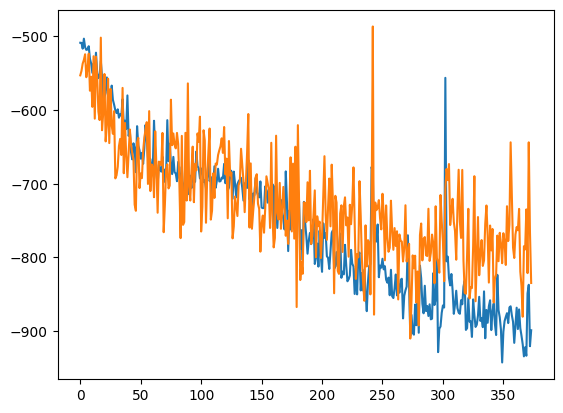

alpha 0.2 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-08-20 19:48:43.208803


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1
predict diverge [-50.47576079  -7.722021   -22.13198117  47.55418414] [-0.6087708   1.20141076  1.25270569 21.77661639] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 185

 2

 3

 4
predict diverge [-15.51574873 -38.58045238 -14.34963147  -0.83187276] [ -0.35724417 -33.51220435   1.84847184 -33.40777125] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 87

 5

 6

 7

 8

 9
predict diverge [-62.82742314 -20.70821218 -24.28254424 -76.27198277] [ -0.67966597  -6.81418323  -1.24138879 -55.5006326 ] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 196
predict diverge [-42.73893301  -7.21581505 -23.8093531  -41.22833091] [ -0.53065898   3.09516567  -1.05139769 -16.79487255] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 171

 10

 11

 12
pr

predict diverge [-42.95520231  -2.50716155 -17.06431764 149.57793182] [ -0.56863232   6.141491     1.77561333 118.74933929] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 144

 67

 68

 69
predict diverge [-12.15448942  19.40762232 -14.67134074 -35.44509877] [ 0.32892654 11.17255809 -1.57145581 -4.89981351] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 75
predict diverge [-30.87354048  14.41006924 -20.95603147 149.33362211] [ -0.49658704  23.78637794   1.68362593 118.25610761] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 139

 70
predict diverge [-22.24262672 -35.24969066 -25.9523034  -37.3251435 ] [ -0.59100338 -23.55435603  -1.2397994   -9.11410307] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 118
predict diverge [ -7.09262658 -24.905

In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.38992  validloss 6.26640±0.00000  bestvalidloss 6.26640  last_update 0
train: iter 1  trainloss 0.77434  validloss 0.64517±0.00000  bestvalidloss 0.64517  last_update 0
train: iter 2  trainloss 0.70087  validloss 0.58421±0.00000  bestvalidloss 0.58421  last_update 0
train: iter 3  trainloss 0.64282  validloss 0.55576±0.00000  bestvalidloss 0.55576  last_update 0
train: iter 4  trainloss 0.60666  validloss 0.52685±0.00000  bestvalidloss 0.52685  last_update 0
train: iter 5  trainloss 0.58432  validloss 0.52296±0.00000  bestvalidloss 0.52296  last_update 0
train: iter 6  trainloss 0.56341  validloss 0.51511±0.00000  bestvalidloss 0.51511  last_update 0
train: iter 7  trainloss 0.55077  validloss 0.50539±0.00000  bestvalidloss 0.50539  last_update 0
train: iter 8  trainloss 0.54231  validloss 0.50663±0.00000  bestvalidloss 0.50539  last_update 1
train: iter 9  trainloss 0.53176  validloss 0.49753±0.00000  bestvalidloss 0.49753  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.39875  validloss 0.44191±0.00000  bestvalidloss 0.42515  last_update 1
train: iter 84  trainloss 0.39449  validloss 0.44209±0.00000  bestvalidloss 0.42515  last_update 2
train: iter 85  trainloss 0.39275  validloss 0.43527±0.00000  bestvalidloss 0.42515  last_update 3
train: iter 86  trainloss 0.38923  validloss 0.42437±0.00000  bestvalidloss 0.42437  last_update 0
train: iter 87  trainloss 0.39811  validloss 0.43951±0.00000  bestvalidloss 0.42437  last_update 1
train: iter 88  trainloss 0.38663  validloss 0.42027±0.00000  bestvalidloss 0.42027  last_update 0
train: iter 89  trainloss 0.40383  validloss 0.43727±0.00000  bestvalidloss 0.42027  last_update 1
train: iter 90  trainloss 0.39070  validloss 0.42708±0.00000  bestvalidloss 0.42027  last_update 2
train: iter 91  trainloss 0.39396  validloss 0.42200±0.00000  bestvalidloss 0.42027  last_update 3
train: iter 92  trainloss 0.38815  validloss 0.42222±0.00000  bestvalidloss 0.42027  last_update 4
train: ite

train: iter 166  trainloss 0.36707  validloss 0.40583±0.00000  bestvalidloss 0.40435  last_update 10
train: iter 167  trainloss 0.36593  validloss 0.40722±0.00000  bestvalidloss 0.40435  last_update 11
train: iter 168  trainloss 0.36244  validloss 0.41175±0.00000  bestvalidloss 0.40435  last_update 12
train: iter 169  trainloss 0.36864  validloss 0.41924±0.00000  bestvalidloss 0.40435  last_update 13
train: iter 170  trainloss 0.36125  validloss 0.41019±0.00000  bestvalidloss 0.40435  last_update 14
train: iter 171  trainloss 0.35928  validloss 0.41012±0.00000  bestvalidloss 0.40435  last_update 15
train: iter 172  trainloss 0.35956  validloss 0.41201±0.00000  bestvalidloss 0.40435  last_update 16
train: iter 173  trainloss 0.35933  validloss 0.42142±0.00000  bestvalidloss 0.40435  last_update 17
train: iter 174  trainloss 0.36019  validloss 0.41092±0.00000  bestvalidloss 0.40435  last_update 18
train: iter 175  trainloss 0.36338  validloss 0.42063±0.00000  bestvalidloss 0.40435  last_

train: iter 248  trainloss 0.33520  validloss 0.40852±0.00000  bestvalidloss 0.39468  last_update 47
train: iter 249  trainloss 0.34142  validloss 0.41499±0.00000  bestvalidloss 0.39468  last_update 48
train: iter 250  trainloss 0.33503  validloss 0.41852±0.00000  bestvalidloss 0.39468  last_update 49
train: iter 251  trainloss 0.34564  validloss 0.42397±0.00000  bestvalidloss 0.39468  last_update 50
train: iter 252  trainloss 0.34176  validloss 0.41578±0.00000  bestvalidloss 0.39468  last_update 51
train: iter 253  trainloss 0.33826  validloss 0.40118±0.00000  bestvalidloss 0.39468  last_update 52
train: iter 254  trainloss 0.33572  validloss 0.41646±0.00000  bestvalidloss 0.39468  last_update 53
train: iter 255  trainloss 0.34516  validloss 0.42431±0.00000  bestvalidloss 0.39468  last_update 54
train: iter 256  trainloss 0.33924  validloss 0.40090±0.00000  bestvalidloss 0.39468  last_update 55
train: iter 257  trainloss 0.34092  validloss 0.40031±0.00000  bestvalidloss 0.39468  last_

train: iter 330  trainloss 0.32946  validloss 0.40901±0.00000  bestvalidloss 0.38347  last_update 15
train: iter 331  trainloss 0.32669  validloss 0.38278±0.00000  bestvalidloss 0.38278  last_update 0
train: iter 332  trainloss 0.32544  validloss 0.40288±0.00000  bestvalidloss 0.38278  last_update 1
train: iter 333  trainloss 0.32797  validloss 0.40177±0.00000  bestvalidloss 0.38278  last_update 2
train: iter 334  trainloss 0.33081  validloss 0.38525±0.00000  bestvalidloss 0.38278  last_update 3
train: iter 335  trainloss 0.32670  validloss 0.40217±0.00000  bestvalidloss 0.38278  last_update 4
train: iter 336  trainloss 0.32612  validloss 0.40698±0.00000  bestvalidloss 0.38278  last_update 5
train: iter 337  trainloss 0.32585  validloss 0.38975±0.00000  bestvalidloss 0.38278  last_update 6
train: iter 338  trainloss 0.32941  validloss 0.38875±0.00000  bestvalidloss 0.38278  last_update 7
train: iter 339  trainloss 0.33056  validloss 0.40482±0.00000  bestvalidloss 0.38278  last_update 8

train: iter 412  trainloss 0.32315  validloss 0.39374±0.00000  bestvalidloss 0.37708  last_update 1
train: iter 413  trainloss 0.31928  validloss 0.38981±0.00000  bestvalidloss 0.37708  last_update 2
train: iter 414  trainloss 0.32355  validloss 0.39187±0.00000  bestvalidloss 0.37708  last_update 3
train: iter 415  trainloss 0.31640  validloss 0.38429±0.00000  bestvalidloss 0.37708  last_update 4
train: iter 416  trainloss 0.31221  validloss 0.37903±0.00000  bestvalidloss 0.37708  last_update 5
train: iter 417  trainloss 0.32260  validloss 0.40871±0.00000  bestvalidloss 0.37708  last_update 6
train: iter 418  trainloss 0.31804  validloss 0.41325±0.00000  bestvalidloss 0.37708  last_update 7
train: iter 419  trainloss 0.32159  validloss 0.38178±0.00000  bestvalidloss 0.37708  last_update 8
train: iter 420  trainloss 0.31472  validloss 0.38314±0.00000  bestvalidloss 0.37708  last_update 9
train: iter 421  trainloss 0.31659  validloss 0.39659±0.00000  bestvalidloss 0.37708  last_update 10

train: iter 494  trainloss 0.31362  validloss 0.37866±0.00000  bestvalidloss 0.36945  last_update 34
train: iter 495  trainloss 0.30500  validloss 0.37123±0.00000  bestvalidloss 0.36945  last_update 35
train: iter 496  trainloss 0.31237  validloss 0.36841±0.00000  bestvalidloss 0.36841  last_update 0
train: iter 497  trainloss 0.31082  validloss 0.39566±0.00000  bestvalidloss 0.36841  last_update 1
train: iter 498  trainloss 0.30737  validloss 0.37810±0.00000  bestvalidloss 0.36841  last_update 2
train: iter 499  trainloss 0.30678  validloss 0.37681±0.00000  bestvalidloss 0.36841  last_update 3
train: iter 500  trainloss 0.31218  validloss 0.38244±0.00000  bestvalidloss 0.36841  last_update 4
train: iter 501  trainloss 0.31297  validloss 0.38635±0.00000  bestvalidloss 0.36841  last_update 5
train: iter 502  trainloss 0.30560  validloss 0.37185±0.00000  bestvalidloss 0.36841  last_update 6
train: iter 503  trainloss 0.30784  validloss 0.38060±0.00000  bestvalidloss 0.36841  last_update 

train: iter 576  trainloss 0.29725  validloss 0.37232±0.00000  bestvalidloss 0.36397  last_update 47
train: iter 577  trainloss 0.29925  validloss 0.39276±0.00000  bestvalidloss 0.36397  last_update 48
train: iter 578  trainloss 0.29976  validloss 0.37481±0.00000  bestvalidloss 0.36397  last_update 49
train: iter 579  trainloss 0.29905  validloss 0.37434±0.00000  bestvalidloss 0.36397  last_update 50
train: iter 580  trainloss 0.30052  validloss 0.37375±0.00000  bestvalidloss 0.36397  last_update 51
train: iter 581  trainloss 0.30135  validloss 0.39441±0.00000  bestvalidloss 0.36397  last_update 52
train: iter 582  trainloss 0.29839  validloss 0.37940±0.00000  bestvalidloss 0.36397  last_update 53
train: iter 583  trainloss 0.29743  validloss 0.36953±0.00000  bestvalidloss 0.36397  last_update 54
train: iter 584  trainloss 0.29923  validloss 0.37445±0.00000  bestvalidloss 0.36397  last_update 55
train: iter 585  trainloss 0.30533  validloss 0.38550±0.00000  bestvalidloss 0.36397  last_

train_loss:  -2.262857862854004
valid_loss:  -2.460725679874421
weight_alpha 1.0 h_min_tilde -11.846514 ell_tilde -2.3024314262580874 kappa_tilde 0.00016184635241364614
train_loss:  -2.364988626003265
valid_loss:  -2.381220566177368
weight_alpha 0.2 h_min_tilde -11.846514 ell_tilde -2.3682350140380857 kappa_tilde 0.00016240719527007202


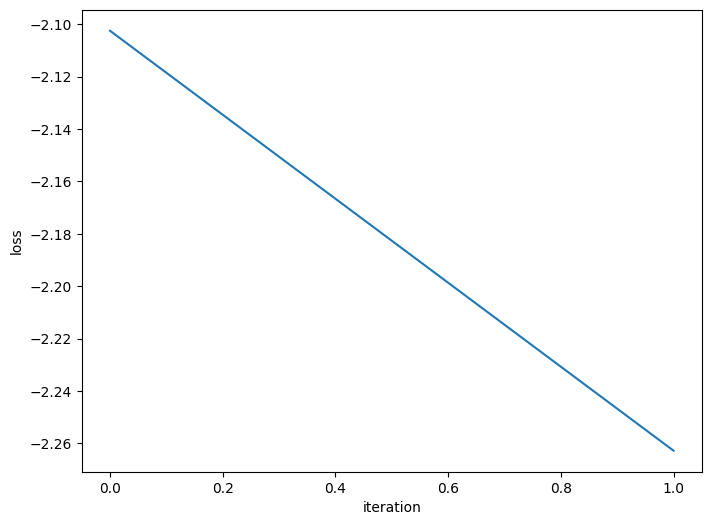

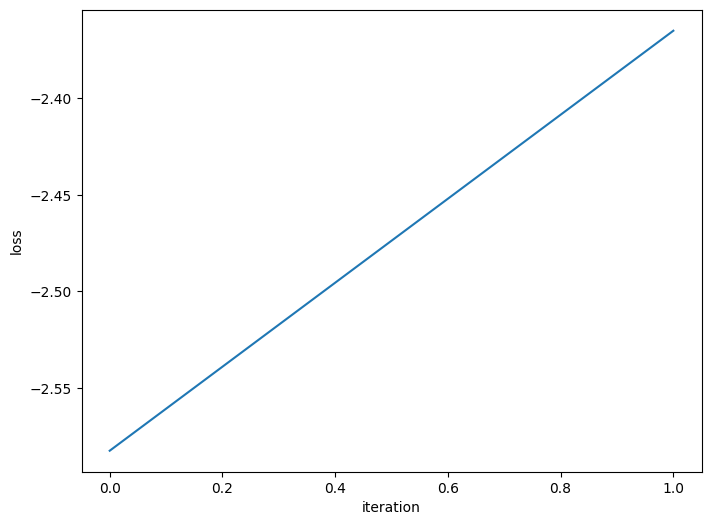

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -463.31211  validloss -476.06285±0.00000  bestvalidloss -476.06285  last_update 0
train: iter 1  trainloss -484.53667  validloss -457.42849±0.00000  bestvalidloss -476.06285  last_update 1
train: iter 2  trainloss -463.00981  validloss -491.22094±0.00000  bestvalidloss -491.22094  last_update 0
train: iter 3  trainloss -472.70330  validloss -501.56578±0.00000  bestvalidloss -501.56578  last_update 0
train: iter 4  trainloss -495.19299  validloss -491.98453±0.00000  bestvalidloss -501.56578  last_update 1
train: iter 5  trainloss -492.44401  validloss -455.42699±0.00000  bestvalidloss -501.56578  last_update 2
train: iter 6  trainloss -504.41538  validloss -490.12601±0.00000  bestvalidloss -501.56578  last_update 3
train: iter 7  trainloss -495.80016  validloss -493.96797±0.00000  bestvalidloss -501.56578  last_update 4
train: iter 8  trainloss -444.33308  validloss -442.29232±0.00000  bestvalidloss -501.56578  last_u

train: iter 76  trainloss -518.35621  validloss -512.82247±0.00000  bestvalidloss -539.45874  last_update 9
train: iter 77  trainloss -510.02554  validloss -518.50766±0.00000  bestvalidloss -539.45874  last_update 10
train: iter 78  trainloss -514.74358  validloss -505.82203±0.00000  bestvalidloss -539.45874  last_update 11
train: iter 79  trainloss -534.40648  validloss -507.59676±0.00000  bestvalidloss -539.45874  last_update 12
train: iter 80  trainloss -530.38011  validloss -526.96800±0.00000  bestvalidloss -539.45874  last_update 13
train: iter 81  trainloss -487.24644  validloss -527.26622±0.00000  bestvalidloss -539.45874  last_update 14
train: iter 82  trainloss -499.34261  validloss -472.87016±0.00000  bestvalidloss -539.45874  last_update 15
train: iter 83  trainloss -517.46361  validloss -503.57135±0.00000  bestvalidloss -539.45874  last_update 16
train: iter 84  trainloss -520.40206  validloss -518.44765±0.00000  bestvalidloss -539.45874  last_update 17
train: iter 85  trai

train: iter 151  trainloss -547.32843  validloss -533.39461±0.00000  bestvalidloss -925.31374  last_update 48
train: iter 152  trainloss -545.65097  validloss -535.81130±0.00000  bestvalidloss -925.31374  last_update 49
train: iter 153  trainloss -550.36320  validloss -558.61427±0.00000  bestvalidloss -925.31374  last_update 50
train: iter 154  trainloss -525.90371  validloss -543.82984±0.00000  bestvalidloss -925.31374  last_update 51
train: iter 155  trainloss -542.39528  validloss -547.35029±0.00000  bestvalidloss -925.31374  last_update 52
train: iter 156  trainloss -519.72576  validloss -528.85296±0.00000  bestvalidloss -925.31374  last_update 53
train: iter 157  trainloss -520.56899  validloss -495.09139±0.00000  bestvalidloss -925.31374  last_update 54
train: iter 158  trainloss -542.91938  validloss -548.49629±0.00000  bestvalidloss -925.31374  last_update 55
train: iter 159  trainloss -545.54495  validloss -544.85426±0.00000  bestvalidloss -925.31374  last_update 56
train: ite

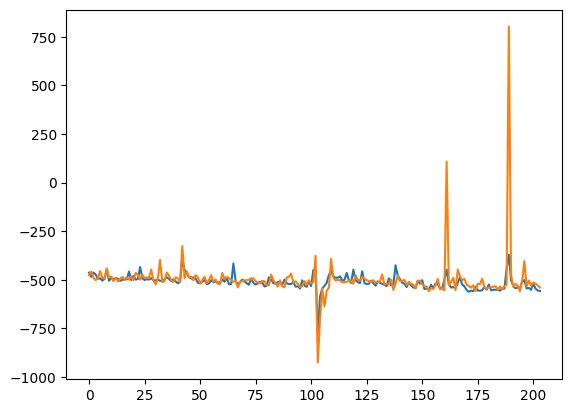

alpha 0.2 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-08-20 20:15:06.056885


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4
predict diverge [-49.90821261  21.38092195   7.09976523  38.43309302] [ 0.2415757  15.28934792  1.75773594  3.15032571] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 187

 5

 6

 7

 8

 9

 10

 11

 12
predict diverge [-67.8181058   11.67991974 -75.73730969 -43.67909975] [ -0.81442605  33.50310242  -2.53924335 -10.72691309] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 185

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27
predict diverge [-48.54553    -26.5083467  -33.2761953  -30.41217182] [ -0.51785574 -16.07165318  -1.64839668   3.68932429] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 197

 28

 29

 30

 31

 32
predict diverge [-58.56404963 -24.80626007  33.17580589  27.76950615] [-0.97222932 -5.52395232  1.6648342   0.59038068] [114.971855  22.17

In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.46902  validloss 0.62147±0.00000  bestvalidloss 0.62147  last_update 0
train: iter 1  trainloss 0.42445  validloss 0.45772±0.00000  bestvalidloss 0.45772  last_update 0
train: iter 2  trainloss 0.39997  validloss 0.43239±0.00000  bestvalidloss 0.43239  last_update 0
train: iter 3  trainloss 0.39670  validloss 0.41472±0.00000  bestvalidloss 0.41472  last_update 0
train: iter 4  trainloss 0.38671  validloss 0.39921±0.00000  bestvalidloss 0.39921  last_update 0
train: iter 5  trainloss 0.38463  validloss 0.40726±0.00000  bestvalidloss 0.39921  last_update 1
train: iter 6  trainloss 0.37870  validloss 0.39894±0.00000  bestvalidloss 0.39894  last_update 0
train: iter 7  trainloss 0.38377  validloss 0.39688±0.00000  bestvalidloss 0.39688  last_update 0
train: iter 8  trainloss 0.37690  validloss 0.40856±0.00000  bestvalidloss 0.39688  last_update 1
train: iter 9  trainloss 0.37858  validloss 0.40475±0.00000  bestvalidloss 0.39688  last_update 2
train: iter 10  trai

train: iter 83  trainloss 0.33217  validloss 0.41000±0.00000  bestvalidloss 0.37829  last_update 9
train: iter 84  trainloss 0.33115  validloss 0.40982±0.00000  bestvalidloss 0.37829  last_update 10
train: iter 85  trainloss 0.33750  validloss 0.39500±0.00000  bestvalidloss 0.37829  last_update 11
train: iter 86  trainloss 0.32990  validloss 0.38892±0.00000  bestvalidloss 0.37829  last_update 12
train: iter 87  trainloss 0.33419  validloss 0.39578±0.00000  bestvalidloss 0.37829  last_update 13
train: iter 88  trainloss 0.33243  validloss 0.39334±0.00000  bestvalidloss 0.37829  last_update 14
train: iter 89  trainloss 0.33420  validloss 0.42099±0.00000  bestvalidloss 0.37829  last_update 15
train: iter 90  trainloss 0.33056  validloss 0.39750±0.00000  bestvalidloss 0.37829  last_update 16
train: iter 91  trainloss 0.32910  validloss 0.39717±0.00000  bestvalidloss 0.37829  last_update 17
train: iter 92  trainloss 0.32792  validloss 0.39437±0.00000  bestvalidloss 0.37829  last_update 18
t

train: iter 166  trainloss 0.31529  validloss 0.42331±0.00000  bestvalidloss 0.37829  last_update 92
train: iter 167  trainloss 0.31563  validloss 0.41821±0.00000  bestvalidloss 0.37829  last_update 93
train: iter 168  trainloss 0.31149  validloss 0.40147±0.00000  bestvalidloss 0.37829  last_update 94
train: iter 169  trainloss 0.31460  validloss 0.39472±0.00000  bestvalidloss 0.37829  last_update 95
train: iter 170  trainloss 0.32028  validloss 0.42311±0.00000  bestvalidloss 0.37829  last_update 96
train: iter 171  trainloss 0.31741  validloss 0.39708±0.00000  bestvalidloss 0.37829  last_update 97
train: iter 172  trainloss 0.31568  validloss 0.41767±0.00000  bestvalidloss 0.37829  last_update 98
train: iter 173  trainloss 0.32115  validloss 0.40869±0.00000  bestvalidloss 0.37829  last_update 99
train: iter 174  trainloss 0.31288  validloss 0.39600±0.00000  bestvalidloss 0.37829  last_update 100
train: fin


train_loss:  -5.067778892058134
valid_loss:  -4.6417308586120605
weight_alpha 1.0 h_min_tilde -11.909423 ell_tilde -4.982569285368919 kappa_tilde 0.000189977426488483
train_loss:  -3.468671791934967
valid_loss:  -3.2711499393463135
weight_alpha 0.2 h_min_tilde -11.909423 ell_tilde -3.429167421417236 kappa_tilde 0.00017169811882295


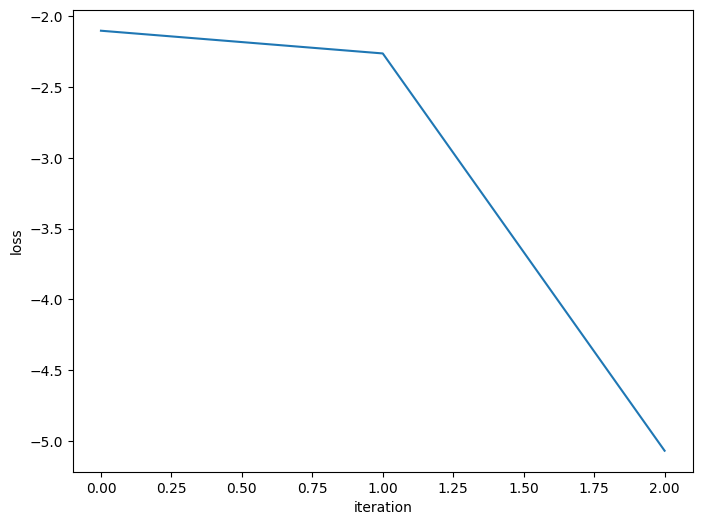

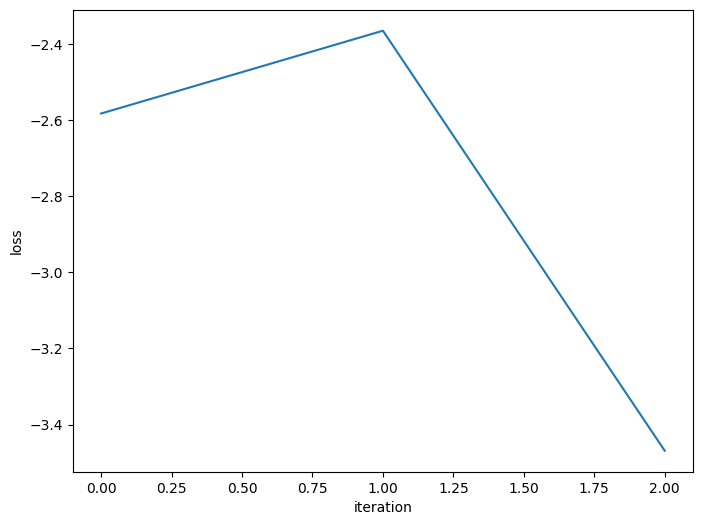

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -677.87113  validloss -655.77756±0.00000  bestvalidloss -655.77756  last_update 0
train: iter 1  trainloss -703.24066  validloss -657.88636±0.00000  bestvalidloss -657.88636  last_update 0
train: iter 2  trainloss -697.17554  validloss -670.86035±0.00000  bestvalidloss -670.86035  last_update 0
train: iter 3  trainloss -649.41575  validloss -567.99513±0.00000  bestvalidloss -670.86035  last_update 1
train: iter 4  trainloss -690.41108  validloss -640.65807±0.00000  bestvalidloss -670.86035  last_update 2
train: iter 5  trainloss -703.81794  validloss -661.65123±0.00000  bestvalidloss -670.86035  last_update 3
train: iter 6  trainloss -693.19196  validloss -669.27119±0.00000  bestvalidloss -670.86035  last_update 4
train: iter 7  trainloss -704.21155  validloss -668.41624±0.00000  bestvalidloss -670.86035  last_update 5
train: iter 8  trainloss -693.86189  validloss -668.81121±0.00000  bestvalidloss -670.86035  last_u

train: iter 76  trainloss -719.13227  validloss -681.67964±0.00000  bestvalidloss -725.99745  last_update 10
train: iter 77  trainloss -698.29311  validloss -701.83675±0.00000  bestvalidloss -725.99745  last_update 11
train: iter 78  trainloss -692.25376  validloss -656.99759±0.00000  bestvalidloss -725.99745  last_update 12
train: iter 79  trainloss -704.56775  validloss -674.44287±0.00000  bestvalidloss -725.99745  last_update 13
train: iter 80  trainloss -726.17730  validloss -701.18059±0.00000  bestvalidloss -725.99745  last_update 14
train: iter 81  trainloss -731.49772  validloss -679.94195±0.00000  bestvalidloss -725.99745  last_update 15
train: iter 82  trainloss -720.80718  validloss -693.87241±0.00000  bestvalidloss -725.99745  last_update 16
train: iter 83  trainloss -613.94348  validloss -659.25927±0.00000  bestvalidloss -725.99745  last_update 17
train: iter 84  trainloss -659.44526  validloss -645.44679±0.00000  bestvalidloss -725.99745  last_update 18
train: iter 85  tra

train: iter 151  trainloss -712.89882  validloss -714.94346±0.00000  bestvalidloss -726.41940  last_update 7
train: iter 152  trainloss -739.07968  validloss -692.09638±0.00000  bestvalidloss -726.41940  last_update 8
train: iter 153  trainloss -752.41302  validloss -705.71472±0.00000  bestvalidloss -726.41940  last_update 9
train: iter 154  trainloss -690.39226  validloss -688.87993±0.00000  bestvalidloss -726.41940  last_update 10
train: iter 155  trainloss -719.90191  validloss -532.10164±0.00000  bestvalidloss -726.41940  last_update 11
train: iter 156  trainloss -743.93895  validloss -689.75010±0.00000  bestvalidloss -726.41940  last_update 12
train: iter 157  trainloss -751.93263  validloss -698.99654±0.00000  bestvalidloss -726.41940  last_update 13
train: iter 158  trainloss -744.64754  validloss -715.01797±0.00000  bestvalidloss -726.41940  last_update 14
train: iter 159  trainloss -732.59510  validloss -682.98519±0.00000  bestvalidloss -726.41940  last_update 15
train: iter 1

train: iter 226  trainloss -771.67568  validloss -731.41790±0.00000  bestvalidloss -739.46212  last_update 6
train: iter 227  trainloss -711.47838  validloss -718.46558±0.00000  bestvalidloss -739.46212  last_update 7
train: iter 228  trainloss -777.53604  validloss -707.83263±0.00000  bestvalidloss -739.46212  last_update 8
train: iter 229  trainloss -774.26309  validloss -731.77288±0.00000  bestvalidloss -739.46212  last_update 9
train: iter 230  trainloss -780.83080  validloss -726.88891±0.00000  bestvalidloss -739.46212  last_update 10
train: iter 231  trainloss -744.91655  validloss -703.56873±0.00000  bestvalidloss -739.46212  last_update 11
train: iter 232  trainloss -738.48781  validloss -677.65073±0.00000  bestvalidloss -739.46212  last_update 12
train: iter 233  trainloss -771.69029  validloss -708.38576±0.00000  bestvalidloss -739.46212  last_update 13
train: iter 234  trainloss -774.78916  validloss -725.15123±0.00000  bestvalidloss -739.46212  last_update 14
train: iter 23

train: iter 301  trainloss -694.68268  validloss -678.67351±0.00000  bestvalidloss -754.59809  last_update 4
train: iter 302  trainloss -721.13273  validloss -676.86529±0.00000  bestvalidloss -754.59809  last_update 5
train: iter 303  trainloss -757.89813  validloss -707.79041±0.00000  bestvalidloss -754.59809  last_update 6
train: iter 304  trainloss -779.88663  validloss -726.81150±0.00000  bestvalidloss -754.59809  last_update 7
train: iter 305  trainloss -753.15785  validloss -735.75243±0.00000  bestvalidloss -754.59809  last_update 8
train: iter 306  trainloss -708.04979  validloss -626.60701±0.00000  bestvalidloss -754.59809  last_update 9
train: iter 307  trainloss -781.86465  validloss -718.94039±0.00000  bestvalidloss -754.59809  last_update 10
train: iter 308  trainloss -800.50689  validloss -739.81212±0.00000  bestvalidloss -754.59809  last_update 11
train: iter 309  trainloss -807.93616  validloss -727.54576±0.00000  bestvalidloss -754.59809  last_update 12
train: iter 310 

train: iter 376  trainloss -803.03626  validloss -740.08828±0.00000  bestvalidloss -760.73897  last_update 37
train: iter 377  trainloss -822.21140  validloss -734.12791±0.00000  bestvalidloss -760.73897  last_update 38
train: iter 378  trainloss -803.09227  validloss -746.21254±0.00000  bestvalidloss -760.73897  last_update 39
train: iter 379  trainloss -791.92350  validloss -729.55929±0.00000  bestvalidloss -760.73897  last_update 40
train: iter 380  trainloss -810.34787  validloss -743.12954±0.00000  bestvalidloss -760.73897  last_update 41
train: iter 381  trainloss -819.20037  validloss -726.49922±0.00000  bestvalidloss -760.73897  last_update 42
train: iter 382  trainloss -807.84851  validloss -744.85109±0.00000  bestvalidloss -760.73897  last_update 43
train: iter 383  trainloss -807.12077  validloss -753.58558±0.00000  bestvalidloss -760.73897  last_update 44
train: iter 384  trainloss -815.19927  validloss -755.68282±0.00000  bestvalidloss -760.73897  last_update 45
train: ite

train: iter 451  trainloss -818.98384  validloss -747.42465±0.00000  bestvalidloss -779.03281  last_update 39
train: iter 452  trainloss -817.57970  validloss -751.15761±0.00000  bestvalidloss -779.03281  last_update 40
train: iter 453  trainloss -795.41317  validloss -650.06802±0.00000  bestvalidloss -779.03281  last_update 41
train: iter 454  trainloss -816.03849  validloss -727.65667±0.00000  bestvalidloss -779.03281  last_update 42
train: iter 455  trainloss -815.37379  validloss -757.81154±0.00000  bestvalidloss -779.03281  last_update 43
train: iter 456  trainloss -818.65397  validloss -740.26479±0.00000  bestvalidloss -779.03281  last_update 44
train: iter 457  trainloss -811.72225  validloss -722.81509±0.00000  bestvalidloss -779.03281  last_update 45
train: iter 458  trainloss -811.42533  validloss -745.90615±0.00000  bestvalidloss -779.03281  last_update 46
train: iter 459  trainloss -812.73627  validloss -758.37291±0.00000  bestvalidloss -779.03281  last_update 47
train: ite

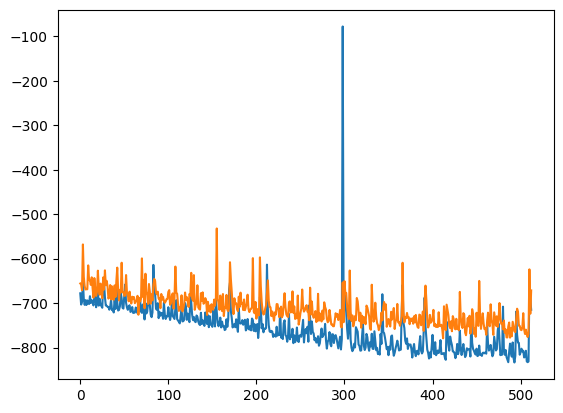

alpha 0.2 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-08-20 20:42:34.924355


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2
predict diverge [-46.36749957  -3.43685756  21.12166055  37.8508831 ] [-0.69189006  7.16559532  1.73440066  7.08142786] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 124

 3

 4

 5
predict diverge [-30.73813404 -10.11105389  17.47292443  36.68076473] [-0.56962445 -1.10302356  1.73411685  5.13275494] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 196

 6
predict diverge [-34.61484874 -19.61457425  26.27757525  36.06513593] [-0.87649933 -3.16385687  1.86638985  3.09052806] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 170

 7

 8

 9

 10

 11

 12

 13
predict diverge [-37.60247099 -16.10822639  38.24662793  38.20458996] [-0.91149159  2.55452878  1.94350915  4.28547512] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 156
predict 


 68
predict diverge [-32.91579873  -6.1550072    3.48572484  36.65185417] [-0.30580805 -1.75266786  1.90969791  2.47270772] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 192

 69

 70

 71

 72
predict diverge [-51.12578958  12.22154861  34.99493366  35.58641077] [0.27084809 1.21708594 1.50144966 6.52880549] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 177

 73
predict diverge [-36.67871892   5.22049438  -0.97302092  36.48205553] [0.02220929 2.16945672 1.96029859 2.08582594] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 194
predict diverge [-25.62166727 -16.90965775  23.08310339  37.23644894] [-0.85318342  1.58124076  1.97589479  3.02890709] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 120

 74
predict diverge [-43.12951164 -17.6709261

In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.99172  validloss 1.91067±0.00000  bestvalidloss 1.91067  last_update 0
train: iter 1  trainloss 0.76389  validloss 1.01771±0.00000  bestvalidloss 1.01771  last_update 0
train: iter 2  trainloss 0.71375  validloss 0.90478±0.00000  bestvalidloss 0.90478  last_update 0
train: iter 3  trainloss 0.68529  validloss 0.89937±0.00000  bestvalidloss 0.89937  last_update 0
train: iter 4  trainloss 0.66288  validloss 0.85879±0.00000  bestvalidloss 0.85879  last_update 0
train: iter 5  trainloss 0.65802  validloss 0.83581±0.00000  bestvalidloss 0.83581  last_update 0
train: iter 6  trainloss 0.64104  validloss 0.83003±0.00000  bestvalidloss 0.83003  last_update 0
train: iter 7  trainloss 0.63805  validloss 0.90605±0.00000  bestvalidloss 0.83003  last_update 1
train: iter 8  trainloss 0.63648  validloss 0.82758±0.00000  bestvalidloss 0.82758  last_update 0
train: iter 9  trainloss 0.62006  validloss 0.83658±0.00000  bestvalidloss 0.82758  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.51019  validloss 0.74706±0.00000  bestvalidloss 0.72232  last_update 21
train: iter 84  trainloss 0.51740  validloss 0.77500±0.00000  bestvalidloss 0.72232  last_update 22
train: iter 85  trainloss 0.50886  validloss 0.71999±0.00000  bestvalidloss 0.71999  last_update 0
train: iter 86  trainloss 0.51240  validloss 0.76884±0.00000  bestvalidloss 0.71999  last_update 1
train: iter 87  trainloss 0.51123  validloss 0.71648±0.00000  bestvalidloss 0.71648  last_update 0
train: iter 88  trainloss 0.51056  validloss 0.76095±0.00000  bestvalidloss 0.71648  last_update 1
train: iter 89  trainloss 0.50396  validloss 0.71721±0.00000  bestvalidloss 0.71648  last_update 2
train: iter 90  trainloss 0.50910  validloss 0.77044±0.00000  bestvalidloss 0.71648  last_update 3
train: iter 91  trainloss 0.50861  validloss 0.74670±0.00000  bestvalidloss 0.71648  last_update 4
train: iter 92  trainloss 0.50521  validloss 0.80781±0.00000  bestvalidloss 0.71648  last_update 5
train: i

train: iter 165  trainloss 0.48984  validloss 0.75444±0.00000  bestvalidloss 0.70683  last_update 49
train: iter 166  trainloss 0.48043  validloss 0.70288±0.00000  bestvalidloss 0.70288  last_update 0
train: iter 167  trainloss 0.47664  validloss 0.73710±0.00000  bestvalidloss 0.70288  last_update 1
train: iter 168  trainloss 0.48150  validloss 0.72779±0.00000  bestvalidloss 0.70288  last_update 2
train: iter 169  trainloss 0.47878  validloss 0.71331±0.00000  bestvalidloss 0.70288  last_update 3
train: iter 170  trainloss 0.48541  validloss 0.72628±0.00000  bestvalidloss 0.70288  last_update 4
train: iter 171  trainloss 0.48275  validloss 0.72978±0.00000  bestvalidloss 0.70288  last_update 5
train: iter 172  trainloss 0.48119  validloss 0.75240±0.00000  bestvalidloss 0.70288  last_update 6
train: iter 173  trainloss 0.47095  validloss 0.70386±0.00000  bestvalidloss 0.70288  last_update 7
train: iter 174  trainloss 0.48553  validloss 0.84252±0.00000  bestvalidloss 0.70288  last_update 8

train: iter 247  trainloss 0.45834  validloss 0.73265±0.00000  bestvalidloss 0.70066  last_update 21
train: iter 248  trainloss 0.46071  validloss 0.78576±0.00000  bestvalidloss 0.70066  last_update 22
train: iter 249  trainloss 0.45602  validloss 0.73275±0.00000  bestvalidloss 0.70066  last_update 23
train: iter 250  trainloss 0.45912  validloss 0.71535±0.00000  bestvalidloss 0.70066  last_update 24
train: iter 251  trainloss 0.45737  validloss 0.74599±0.00000  bestvalidloss 0.70066  last_update 25
train: iter 252  trainloss 0.46254  validloss 0.82871±0.00000  bestvalidloss 0.70066  last_update 26
train: iter 253  trainloss 0.46195  validloss 0.72120±0.00000  bestvalidloss 0.70066  last_update 27
train: iter 254  trainloss 0.45888  validloss 0.74195±0.00000  bestvalidloss 0.70066  last_update 28
train: iter 255  trainloss 0.45915  validloss 0.70634±0.00000  bestvalidloss 0.70066  last_update 29
train: iter 256  trainloss 0.46233  validloss 0.73785±0.00000  bestvalidloss 0.70066  last_

train: iter 329  trainloss 0.43924  validloss 0.74397±0.00000  bestvalidloss 0.70039  last_update 47
train: iter 330  trainloss 0.43998  validloss 0.79168±0.00000  bestvalidloss 0.70039  last_update 48
train: iter 331  trainloss 0.44237  validloss 0.74980±0.00000  bestvalidloss 0.70039  last_update 49
train: iter 332  trainloss 0.44702  validloss 0.79801±0.00000  bestvalidloss 0.70039  last_update 50
train: iter 333  trainloss 0.44959  validloss 0.73746±0.00000  bestvalidloss 0.70039  last_update 51
train: iter 334  trainloss 0.45051  validloss 0.73820±0.00000  bestvalidloss 0.70039  last_update 52
train: iter 335  trainloss 0.44446  validloss 0.74024±0.00000  bestvalidloss 0.70039  last_update 53
train: iter 336  trainloss 0.45166  validloss 0.78249±0.00000  bestvalidloss 0.70039  last_update 54
train: iter 337  trainloss 0.43758  validloss 0.74709±0.00000  bestvalidloss 0.70039  last_update 55
train: iter 338  trainloss 0.44009  validloss 0.75926±0.00000  bestvalidloss 0.70039  last_

train: iter 411  trainloss 0.42923  validloss 0.73845±0.00000  bestvalidloss 0.70035  last_update 33
train: iter 412  trainloss 0.43458  validloss 0.75585±0.00000  bestvalidloss 0.70035  last_update 34
train: iter 413  trainloss 0.42853  validloss 0.77278±0.00000  bestvalidloss 0.70035  last_update 35
train: iter 414  trainloss 0.43636  validloss 0.75781±0.00000  bestvalidloss 0.70035  last_update 36
train: iter 415  trainloss 0.43715  validloss 0.78573±0.00000  bestvalidloss 0.70035  last_update 37
train: iter 416  trainloss 0.42859  validloss 0.74847±0.00000  bestvalidloss 0.70035  last_update 38
train: iter 417  trainloss 0.42591  validloss 0.76128±0.00000  bestvalidloss 0.70035  last_update 39
train: iter 418  trainloss 0.42719  validloss 0.75813±0.00000  bestvalidloss 0.70035  last_update 40
train: iter 419  trainloss 0.42709  validloss 0.73624±0.00000  bestvalidloss 0.70035  last_update 41
train: iter 420  trainloss 0.43513  validloss 0.76800±0.00000  bestvalidloss 0.70035  last_

train: iter 493  trainloss 0.43081  validloss 0.77168±0.00000  bestvalidloss 0.69419  last_update 58
train: iter 494  trainloss 0.41958  validloss 0.74627±0.00000  bestvalidloss 0.69419  last_update 59
train: iter 495  trainloss 0.42713  validloss 0.81128±0.00000  bestvalidloss 0.69419  last_update 60
train: iter 496  trainloss 0.41855  validloss 0.80176±0.00000  bestvalidloss 0.69419  last_update 61
train: iter 497  trainloss 0.42208  validloss 0.84751±0.00000  bestvalidloss 0.69419  last_update 62
train: iter 498  trainloss 0.42263  validloss 0.73568±0.00000  bestvalidloss 0.69419  last_update 63
train: iter 499  trainloss 0.42215  validloss 0.78271±0.00000  bestvalidloss 0.69419  last_update 64
train: iter 500  trainloss 0.41681  validloss 0.75425±0.00000  bestvalidloss 0.69419  last_update 65
train: iter 501  trainloss 0.42223  validloss 0.78216±0.00000  bestvalidloss 0.69419  last_update 66
train: iter 502  trainloss 0.42030  validloss 0.81526±0.00000  bestvalidloss 0.69419  last_

train_loss:  -4.143048933929206
valid_loss:  -3.200042066192627
weight_alpha 1.0 h_min_tilde -11.843361 ell_tilde -3.954447560381891 kappa_tilde 0.00017801697284752194
train_loss:  -3.3843036450624466
valid_loss:  -3.35520773639679
weight_alpha 0.2 h_min_tilde -11.843361 ell_tilde -3.378484463329315 kappa_tilde 0.0001718540188999653


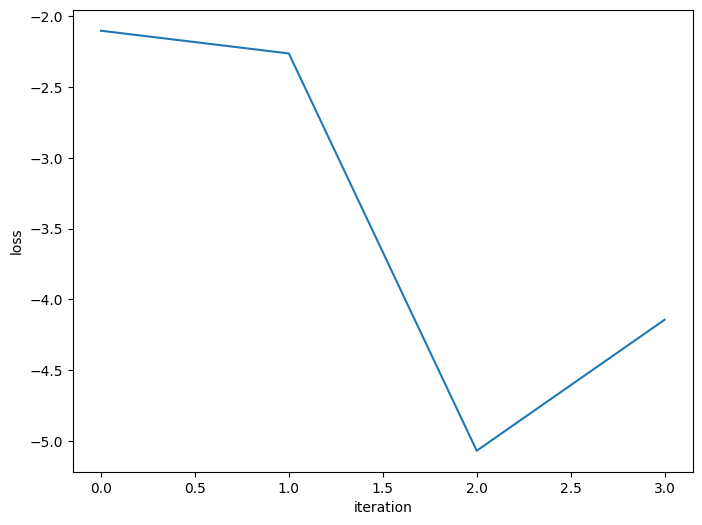

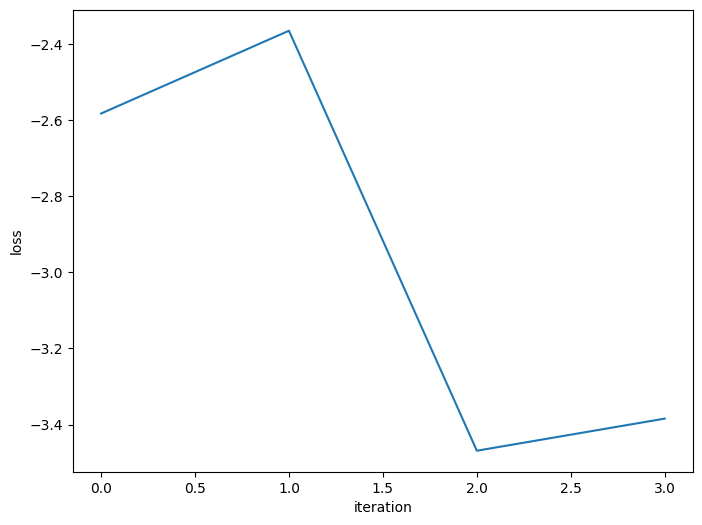

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -692.43199  validloss -675.23414±0.00000  bestvalidloss -675.23414  last_update 0
train: iter 1  trainloss -721.60138  validloss -732.62206±0.00000  bestvalidloss -732.62206  last_update 0
train: iter 2  trainloss -724.05998  validloss -702.61669±0.00000  bestvalidloss -732.62206  last_update 1
train: iter 3  trainloss -644.48108  validloss -729.25390±0.00000  bestvalidloss -732.62206  last_update 2
train: iter 4  trainloss -727.37314  validloss -681.56173±0.00000  bestvalidloss -732.62206  last_update 3
train: iter 5  trainloss -751.04663  validloss -703.46877±0.00000  bestvalidloss -732.62206  last_update 4
train: iter 6  trainloss -778.11630  validloss -754.88512±0.00000  bestvalidloss -754.88512  last_update 0
train: iter 7  trainloss -757.52123  validloss -766.08619±0.00000  bestvalidloss -766.08619  last_update 0
train: iter 8  trainloss -789.21861  validloss -798.86703±0.00000  bestvalidloss -798.86703  last_u

train: iter 76  trainloss -778.59701  validloss -786.00854±0.00000  bestvalidloss -854.78343  last_update 3
train: iter 77  trainloss -787.31317  validloss -758.80107±0.00000  bestvalidloss -854.78343  last_update 4
train: iter 78  trainloss -788.41206  validloss -748.77168±0.00000  bestvalidloss -854.78343  last_update 5
train: iter 79  trainloss -776.54266  validloss -775.20699±0.00000  bestvalidloss -854.78343  last_update 6
train: iter 80  trainloss -794.05078  validloss -807.91127±0.00000  bestvalidloss -854.78343  last_update 7
train: iter 81  trainloss -713.42702  validloss -776.29017±0.00000  bestvalidloss -854.78343  last_update 8
train: iter 82  trainloss -714.54364  validloss -730.73187±0.00000  bestvalidloss -854.78343  last_update 9
train: iter 83  trainloss -756.02456  validloss -748.93180±0.00000  bestvalidloss -854.78343  last_update 10
train: iter 84  trainloss -801.51181  validloss -798.68799±0.00000  bestvalidloss -854.78343  last_update 11
train: iter 85  trainloss 

train: iter 151  trainloss -808.78682  validloss -820.66746±0.00000  bestvalidloss -940.64685  last_update 40
train: iter 152  trainloss -739.42974  validloss -819.12350±0.00000  bestvalidloss -940.64685  last_update 41
train: iter 153  trainloss -747.68906  validloss -736.33005±0.00000  bestvalidloss -940.64685  last_update 42
train: iter 154  trainloss -789.50675  validloss -747.67954±0.00000  bestvalidloss -940.64685  last_update 43
train: iter 155  trainloss -803.15278  validloss -758.19849±0.00000  bestvalidloss -940.64685  last_update 44
train: iter 156  trainloss -806.38011  validloss -740.92110±0.00000  bestvalidloss -940.64685  last_update 45
train: iter 157  trainloss -805.67853  validloss -803.76338±0.00000  bestvalidloss -940.64685  last_update 46
train: iter 158  trainloss -802.38841  validloss -821.42423±0.00000  bestvalidloss -940.64685  last_update 47
train: iter 159  trainloss -770.62436  validloss -794.75180±0.00000  bestvalidloss -940.64685  last_update 48
train: ite

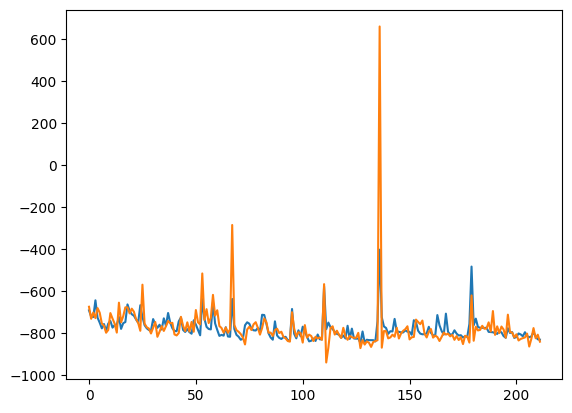

alpha 0.2 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-08-20 21:08:57.895170


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20
predict diverge [-38.48970104 -22.21320107  37.66874878  25.86613024] [-1.03989459 -0.43126882  1.35979254  1.73508828] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 178

 21

 22

 23

 24

 25

 26

 27

 28

 29
predict diverge [-35.93849693  17.60696631  23.47521051  35.8460587 ] [0.32728599 2.43581549 1.61301725 2.92309148] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 170

 30

 31

 32
predict diverge [-51.17844809 -22.58043662  31.96405316  22.98938321] [-1.04799096 -1.24507471  1.25304186  1.00631703] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 196

 33
predict diverge [-57.58901938 -22.55797671  32.30247452  19.2401058 ] [-1.11215513 -0.58636919  1.15110039 -0.94837127] [114.971855  22.171711 20

In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.80314  validloss 1.18649±0.00000  bestvalidloss 1.18649  last_update 0
train: iter 1  trainloss 0.71923  validloss 0.87423±0.00000  bestvalidloss 0.87423  last_update 0
train: iter 2  trainloss 0.70646  validloss 0.85217±0.00000  bestvalidloss 0.85217  last_update 0
train: iter 3  trainloss 0.69413  validloss 0.82547±0.00000  bestvalidloss 0.82547  last_update 0
train: iter 4  trainloss 0.67708  validloss 0.80810±0.00000  bestvalidloss 0.80810  last_update 0
train: iter 5  trainloss 0.67365  validloss 0.80867±0.00000  bestvalidloss 0.80810  last_update 1
train: iter 6  trainloss 0.66181  validloss 0.81323±0.00000  bestvalidloss 0.80810  last_update 2
train: iter 7  trainloss 0.65388  validloss 0.79710±0.00000  bestvalidloss 0.79710  last_update 0
train: iter 8  trainloss 0.66181  validloss 0.81572±0.00000  bestvalidloss 0.79710  last_update 1
train: iter 9  trainloss 0.64313  validloss 0.77760±0.00000  bestvalidloss 0.77760  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.56796  validloss 0.74104±0.00000  bestvalidloss 0.71744  last_update 7
train: iter 84  trainloss 0.56437  validloss 0.73097±0.00000  bestvalidloss 0.71744  last_update 8
train: iter 85  trainloss 0.56476  validloss 0.73260±0.00000  bestvalidloss 0.71744  last_update 9
train: iter 86  trainloss 0.56401  validloss 0.74312±0.00000  bestvalidloss 0.71744  last_update 10
train: iter 87  trainloss 0.56703  validloss 0.72510±0.00000  bestvalidloss 0.71744  last_update 11
train: iter 88  trainloss 0.56543  validloss 0.74409±0.00000  bestvalidloss 0.71744  last_update 12
train: iter 89  trainloss 0.56407  validloss 0.73224±0.00000  bestvalidloss 0.71744  last_update 13
train: iter 90  trainloss 0.56928  validloss 0.78909±0.00000  bestvalidloss 0.71744  last_update 14
train: iter 91  trainloss 0.56180  validloss 0.72176±0.00000  bestvalidloss 0.71744  last_update 15
train: iter 92  trainloss 0.56520  validloss 0.71991±0.00000  bestvalidloss 0.71744  last_update 16
tra

train: iter 165  trainloss 0.53410  validloss 0.73519±0.00000  bestvalidloss 0.71134  last_update 67
train: iter 166  trainloss 0.53574  validloss 0.74475±0.00000  bestvalidloss 0.71134  last_update 68
train: iter 167  trainloss 0.53888  validloss 0.74806±0.00000  bestvalidloss 0.71134  last_update 69
train: iter 168  trainloss 0.53793  validloss 0.73589±0.00000  bestvalidloss 0.71134  last_update 70
train: iter 169  trainloss 0.54033  validloss 0.78194±0.00000  bestvalidloss 0.71134  last_update 71
train: iter 170  trainloss 0.54436  validloss 0.74210±0.00000  bestvalidloss 0.71134  last_update 72
train: iter 171  trainloss 0.53035  validloss 0.72874±0.00000  bestvalidloss 0.71134  last_update 73
train: iter 172  trainloss 0.53752  validloss 0.73147±0.00000  bestvalidloss 0.71134  last_update 74
train: iter 173  trainloss 0.53591  validloss 0.74109±0.00000  bestvalidloss 0.71134  last_update 75
train: iter 174  trainloss 0.53213  validloss 0.72646±0.00000  bestvalidloss 0.71134  last_

train_loss:  -6.805394431766868
valid_loss:  -7.2683694219589245
weight_alpha 1.0 h_min_tilde -11.611969 ell_tilde -6.897989429805279 kappa_tilde 0.00023029057099562998
train_loss:  -4.357831828570366
valid_loss:  -4.576019578933716
weight_alpha 0.2 h_min_tilde -11.611969 ell_tilde -4.401469378643036 kappa_tilde 0.00018620327933335814


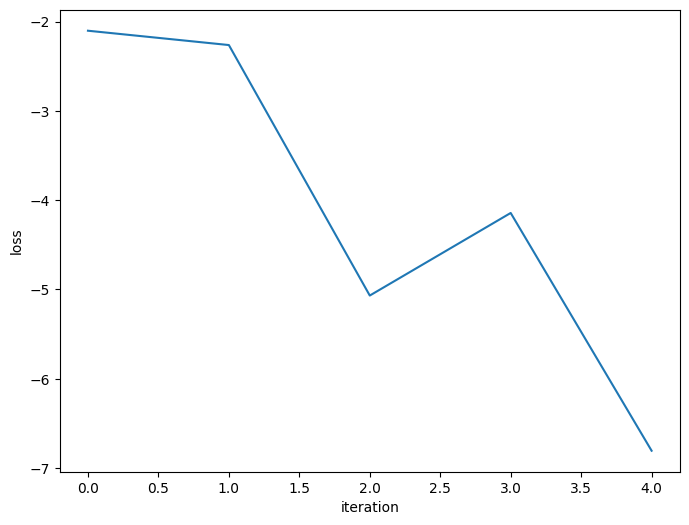

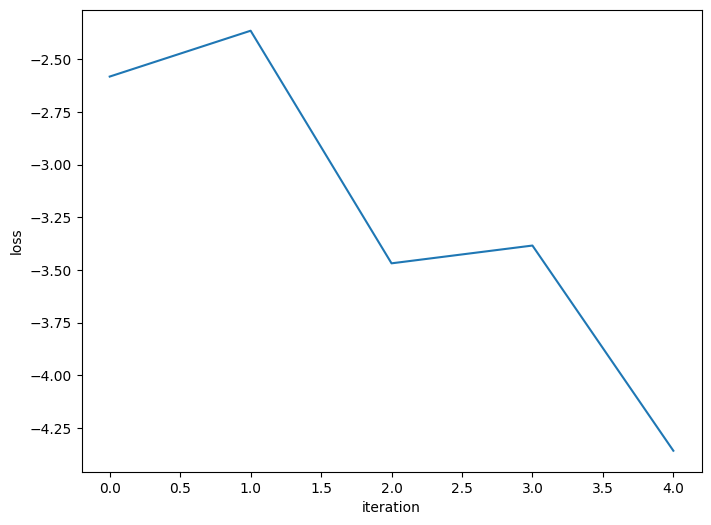

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -857.64721  validloss -920.25160±0.00000  bestvalidloss -920.25160  last_update 0
train: iter 1  trainloss -875.76592  validloss -857.84457±0.00000  bestvalidloss -920.25160  last_update 1
train: iter 2  trainloss -878.55066  validloss -909.03101±0.00000  bestvalidloss -920.25160  last_update 2
train: iter 3  trainloss -874.61519  validloss -900.11139±0.00000  bestvalidloss -920.25160  last_update 3
train: iter 4  trainloss -855.32561  validloss -872.08236±0.00000  bestvalidloss -920.25160  last_update 4
train: iter 5  trainloss -863.70801  validloss -884.68554±0.00000  bestvalidloss -920.25160  last_update 5
train: iter 6  trainloss -877.85852  validloss -921.15482±0.00000  bestvalidloss -921.15482  last_update 0
train: iter 7  trainloss -859.86447  validloss -897.58697±0.00000  bestvalidloss -921.15482  last_update 1
train: iter 8  trainloss -853.94434  validloss -899.29649±0.00000  bestvalidloss -921.15482  last_u

train: iter 76  trainloss -906.94148  validloss -914.68932±0.00000  bestvalidloss -963.15770  last_update 3
train: iter 77  trainloss -901.06052  validloss -930.69555±0.00000  bestvalidloss -963.15770  last_update 4
train: iter 78  trainloss -867.41801  validloss -969.89021±0.00000  bestvalidloss -969.89021  last_update 0
train: iter 79  trainloss -888.33208  validloss -933.16950±0.00000  bestvalidloss -969.89021  last_update 1
train: iter 80  trainloss -901.42940  validloss -921.79901±0.00000  bestvalidloss -969.89021  last_update 2
train: iter 81  trainloss -894.47804  validloss -936.26791±0.00000  bestvalidloss -969.89021  last_update 3
train: iter 82  trainloss -907.35472  validloss -934.67232±0.00000  bestvalidloss -969.89021  last_update 4
train: iter 83  trainloss -894.62862  validloss -938.13527±0.00000  bestvalidloss -969.89021  last_update 5
train: iter 84  trainloss -914.22920  validloss -939.10050±0.00000  bestvalidloss -969.89021  last_update 6
train: iter 85  trainloss -9

train: iter 151  trainloss -911.15446  validloss -973.82751±0.00000  bestvalidloss -987.90583  last_update 11
train: iter 152  trainloss -927.26450  validloss -908.16664±0.00000  bestvalidloss -987.90583  last_update 12
train: iter 153  trainloss -938.28354  validloss -952.15493±0.00000  bestvalidloss -987.90583  last_update 13
train: iter 154  trainloss -921.98556  validloss -957.71344±0.00000  bestvalidloss -987.90583  last_update 14
train: iter 155  trainloss -866.58414  validloss -935.55246±0.00000  bestvalidloss -987.90583  last_update 15
train: iter 156  trainloss -903.53447  validloss -932.93339±0.00000  bestvalidloss -987.90583  last_update 16
train: iter 157  trainloss -935.14183  validloss -953.40709±0.00000  bestvalidloss -987.90583  last_update 17
train: iter 158  trainloss -928.38073  validloss -963.69385±0.00000  bestvalidloss -987.90583  last_update 18
train: iter 159  trainloss -928.92680  validloss -975.86372±0.00000  bestvalidloss -987.90583  last_update 19
train: ite

train: iter 226  trainloss -957.26630  validloss -991.05485±0.00000  bestvalidloss -1020.68806  last_update 18
train: iter 227  trainloss -945.37136  validloss -943.95930±0.00000  bestvalidloss -1020.68806  last_update 19
train: iter 228  trainloss -922.05353  validloss -990.04134±0.00000  bestvalidloss -1020.68806  last_update 20
train: iter 229  trainloss -880.35583  validloss -913.85444±0.00000  bestvalidloss -1020.68806  last_update 21
train: iter 230  trainloss -923.19858  validloss -934.01236±0.00000  bestvalidloss -1020.68806  last_update 22
train: iter 231  trainloss -934.09890  validloss -936.32393±0.00000  bestvalidloss -1020.68806  last_update 23
train: iter 232  trainloss -938.12199  validloss -956.92683±0.00000  bestvalidloss -1020.68806  last_update 24
train: iter 233  trainloss -906.92301  validloss -984.07954±0.00000  bestvalidloss -1020.68806  last_update 25
train: iter 234  trainloss -917.35944  validloss -796.74856±0.00000  bestvalidloss -1020.68806  last_update 26
t

train: iter 300  trainloss -955.58543  validloss -1031.01508±0.00000  bestvalidloss -1040.56335  last_update 5
train: iter 301  trainloss -931.86350  validloss -874.08825±0.00000  bestvalidloss -1040.56335  last_update 6
train: iter 302  trainloss -968.19115  validloss -1015.52732±0.00000  bestvalidloss -1040.56335  last_update 7
train: iter 303  trainloss -970.79025  validloss -1022.05215±0.00000  bestvalidloss -1040.56335  last_update 8
train: iter 304  trainloss -955.81887  validloss -1002.08753±0.00000  bestvalidloss -1040.56335  last_update 9
train: iter 305  trainloss -975.15909  validloss -1054.47720±0.00000  bestvalidloss -1054.47720  last_update 0
train: iter 306  trainloss -972.90608  validloss -1047.01189±0.00000  bestvalidloss -1054.47720  last_update 1
train: iter 307  trainloss -981.11696  validloss -1016.16096±0.00000  bestvalidloss -1054.47720  last_update 2
train: iter 308  trainloss -969.85720  validloss -983.55142±0.00000  bestvalidloss -1054.47720  last_update 3
tra

train: iter 374  trainloss -971.24886  validloss -997.01828±0.00000  bestvalidloss -1054.88436  last_update 37
train: iter 375  trainloss -906.98933  validloss -1041.70226±0.00000  bestvalidloss -1054.88436  last_update 38
train: iter 376  trainloss -966.11284  validloss -987.32017±0.00000  bestvalidloss -1054.88436  last_update 39
train: iter 377  trainloss -978.45664  validloss -1043.02569±0.00000  bestvalidloss -1054.88436  last_update 40
train: iter 378  trainloss -958.72764  validloss -1008.12540±0.00000  bestvalidloss -1054.88436  last_update 41
train: iter 379  trainloss -988.82827  validloss -1065.70960±0.00000  bestvalidloss -1065.70960  last_update 0
train: iter 380  trainloss -991.04395  validloss -1027.25617±0.00000  bestvalidloss -1065.70960  last_update 1
train: iter 381  trainloss -988.81097  validloss -1049.60891±0.00000  bestvalidloss -1065.70960  last_update 2
train: iter 382  trainloss -981.00892  validloss -1028.56496±0.00000  bestvalidloss -1065.70960  last_update 

train: iter 448  trainloss -985.27339  validloss -1032.66579±0.00000  bestvalidloss -1088.60069  last_update 51
train: iter 449  trainloss -973.80691  validloss -966.24360±0.00000  bestvalidloss -1088.60069  last_update 52
train: iter 450  trainloss -989.65670  validloss -1000.06398±0.00000  bestvalidloss -1088.60069  last_update 53
train: iter 451  trainloss -994.17134  validloss -1041.57125±0.00000  bestvalidloss -1088.60069  last_update 54
train: iter 452  trainloss -995.15479  validloss -1025.07408±0.00000  bestvalidloss -1088.60069  last_update 55
train: iter 453  trainloss -978.09332  validloss -1013.74075±0.00000  bestvalidloss -1088.60069  last_update 56
train: iter 454  trainloss -998.92737  validloss -1034.80038±0.00000  bestvalidloss -1088.60069  last_update 57
train: iter 455  trainloss -999.76615  validloss -1035.36281±0.00000  bestvalidloss -1088.60069  last_update 58
train: iter 456  trainloss -995.76512  validloss -1044.23887±0.00000  bestvalidloss -1088.60069  last_upd

train: iter 522  trainloss -1017.78267  validloss -1107.82610±0.00000  bestvalidloss -1108.15455  last_update 39
train: iter 523  trainloss -992.20627  validloss -1068.19309±0.00000  bestvalidloss -1108.15455  last_update 40
train: iter 524  trainloss -1019.73781  validloss -1075.54575±0.00000  bestvalidloss -1108.15455  last_update 41
train: iter 525  trainloss -1002.96821  validloss -1078.36746±0.00000  bestvalidloss -1108.15455  last_update 42
train: iter 526  trainloss -975.10704  validloss -1093.92943±0.00000  bestvalidloss -1108.15455  last_update 43
train: iter 527  trainloss -1009.93782  validloss -1099.60078±0.00000  bestvalidloss -1108.15455  last_update 44
train: iter 528  trainloss -993.57670  validloss -1059.48320±0.00000  bestvalidloss -1108.15455  last_update 45
train: iter 529  trainloss -1005.52681  validloss -1089.03185±0.00000  bestvalidloss -1108.15455  last_update 46
train: iter 530  trainloss -1013.00040  validloss -1105.87108±0.00000  bestvalidloss -1108.15455  l

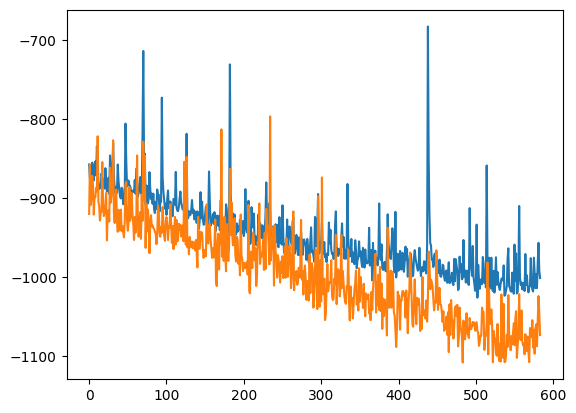

alpha 0.2 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-08-20 21:38:13.431521


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52
predict diverge [-33.08637099  -5.8529535   60.88739705  35.58545237] [-0.06103144 -5.13017729  1.75840107  0.69620957] [114.971855  22.171711 208.57098   35.36111 ] [ 57.485928   11.0858555 104.28549    17.680555 ] sim_timestep 127

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.78074  validloss 0.82992±0.00000  bestvalidloss 0.82992  last_update 0
train: iter 1  trainloss 0.72082  validloss 0.70010±0.00000  bestvalidloss 0.70010  last_update 0
train: iter 2  trainloss 0.69525  validloss 0.70295±0.00000  bestvalidloss 0.70010  last_update 1
train: iter 3  trainloss 0.67731  validloss 0.69701±0.00000  bestvalidloss 0.69701  last_update 0
train: iter 4  trainloss 0.67439  validloss 0.70033±0.00000  bestvalidloss 0.69701  last_update 1
train: iter 5  trainloss 0.66136  validloss 0.69708±0.00000  bestvalidloss 0.69701  last_update 2
train: iter 6  trainloss 0.65497  validloss 0.71102±0.00000  bestvalidloss 0.69701  last_update 3
train: iter 7  trainloss 0.64879  validloss 0.73226±0.00000  bestvalidloss 0.69701  last_update 4
train: iter 8  trainloss 0.64451  validloss 0.69865±0.00000  bestvalidloss 0.69701  last_update 5
train: iter 9  trainloss 0.63807  validloss 0.71498±0.00000  bestvalidloss 0.69701  last_update 6
train: iter 10  trai

train: iter 83  trainloss 0.56292  validloss 0.71664±0.00000  bestvalidloss 0.68808  last_update 28
train: iter 84  trainloss 0.55237  validloss 0.70223±0.00000  bestvalidloss 0.68808  last_update 29
train: iter 85  trainloss 0.55746  validloss 0.71786±0.00000  bestvalidloss 0.68808  last_update 30
train: iter 86  trainloss 0.55563  validloss 0.70033±0.00000  bestvalidloss 0.68808  last_update 31
train: iter 87  trainloss 0.55292  validloss 0.70441±0.00000  bestvalidloss 0.68808  last_update 32
train: iter 88  trainloss 0.56097  validloss 0.71127±0.00000  bestvalidloss 0.68808  last_update 33
train: iter 89  trainloss 0.55463  validloss 0.74817±0.00000  bestvalidloss 0.68808  last_update 34
train: iter 90  trainloss 0.56534  validloss 0.70927±0.00000  bestvalidloss 0.68808  last_update 35
train: iter 91  trainloss 0.55676  validloss 0.68869±0.00000  bestvalidloss 0.68808  last_update 36
train: iter 92  trainloss 0.55073  validloss 0.68971±0.00000  bestvalidloss 0.68808  last_update 37


train: iter 165  trainloss 0.53344  validloss 0.69389±0.00000  bestvalidloss 0.68557  last_update 19
train: iter 166  trainloss 0.53816  validloss 0.70066±0.00000  bestvalidloss 0.68557  last_update 20
train: iter 167  trainloss 0.53891  validloss 0.70086±0.00000  bestvalidloss 0.68557  last_update 21
train: iter 168  trainloss 0.54611  validloss 0.75475±0.00000  bestvalidloss 0.68557  last_update 22
train: iter 169  trainloss 0.53908  validloss 0.72903±0.00000  bestvalidloss 0.68557  last_update 23
train: iter 170  trainloss 0.53517  validloss 0.70184±0.00000  bestvalidloss 0.68557  last_update 24
train: iter 171  trainloss 0.53678  validloss 0.70586±0.00000  bestvalidloss 0.68557  last_update 25
train: iter 172  trainloss 0.52651  validloss 0.72340±0.00000  bestvalidloss 0.68557  last_update 26
train: iter 173  trainloss 0.54212  validloss 0.71119±0.00000  bestvalidloss 0.68557  last_update 27
train: iter 174  trainloss 0.53243  validloss 0.72293±0.00000  bestvalidloss 0.68557  last_

([0.780741335451603,
  0.7208225239999593,
  0.6952521176077425,
  0.6773126471787692,
  0.6743937490507961,
  0.6613617349416018,
  0.6549704421311617,
  0.6487886309623718,
  0.6445064917206764,
  0.6380666512995958,
  0.6305644316598773,
  0.6315411588177084,
  0.6263758456334472,
  0.6215790120884777,
  0.6188503108918667,
  0.6146783821284771,
  0.6177669653669,
  0.6140134239569306,
  0.6055716369301081,
  0.6043272279202938,
  0.5999852495267988,
  0.6034493600949645,
  0.5991482863202691,
  0.5958324732258916,
  0.596869932115078,
  0.5911636304110288,
  0.5922743992879986,
  0.5967512809671461,
  0.5944898666813969,
  0.5902926517650485,
  0.5877617575228214,
  0.5887478873133659,
  0.5891085017472506,
  0.5813558902591467,
  0.5834685001522303,
  0.5877336405217648,
  0.5801580341532826,
  0.5750977901741863,
  0.5881986861117184,
  0.5807817816734314,
  0.5758631236851215,
  0.5731376757845282,
  0.5686484843492507,
  0.5758915649726987,
  0.5730711260810495,
  0.57683003395

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -7.318094879812003
valid_loss:  -8.920365205192565
weight_alpha 1.0 h_min_tilde -11.926315 ell_tilde -7.638548944888115 kappa_tilde 0.0002414651437631607
train_loss:  -4.638562031936646
valid_loss:  -5.032699648284912
weight_alpha 0.2 h_min_tilde -11.926315 ell_tilde -4.7173895552062985 kappa_tilde 0.00018622360430857213


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 45.68231  validloss 49.56378±0.00000  bestvalidloss 49.56378  last_update 0
train: iter 1  trainloss 38.60569  validloss 41.53342±0.00000  bestvalidloss 41.53342  last_update 0
train: iter 2  trainloss 32.68500  validloss 35.07972±0.00000  bestvalidloss 35.07972  last_update 0
train: iter 3  trainloss 27.81948  validloss 29.81207±0.00000  bestvalidloss 29.81207  last_update 0
train: iter 4  trainloss 24.03715  validloss 25.48719±0.00000  bestvalidloss 25.48719  last_update 0
train: iter 5  trainloss 20.64683  validloss 21.60203±0.00000  bestvalidloss 21.60203  last_update 0
train: iter 6  trainloss 17.99125  validloss 18.94368±0.00000  bestvalidloss 18.94368  last_update 0
train: iter 7  trainloss 15.69382  validloss 16.56026±0.00000  bestvalidloss 16.56026  last_update 0
train: iter 8  trainloss 13.65284  validloss 14.27218±0.00000  bestvalidloss 14.27218  last_update 0
train: iter 9  trainloss 12.00133  validloss 12.48792±0.00000  bestvalidloss 12.48792  last

train: iter 98  trainloss -0.21966  validloss -0.45697±0.00000  bestvalidloss -0.45697  last_update 0
train: iter 99  trainloss -0.25108  validloss -0.50022±0.00000  bestvalidloss -0.50022  last_update 0
train: iter 100  trainloss -0.26359  validloss -0.52921±0.00000  bestvalidloss -0.52921  last_update 0
train: iter 101  trainloss -0.26596  validloss -0.50699±0.00000  bestvalidloss -0.52921  last_update 1
train: iter 102  trainloss -0.28957  validloss -0.52256±0.00000  bestvalidloss -0.52921  last_update 2
train: iter 103  trainloss -0.28348  validloss -0.54704±0.00000  bestvalidloss -0.54704  last_update 0
train: iter 104  trainloss -0.29301  validloss -0.53305±0.00000  bestvalidloss -0.54704  last_update 1
train: iter 105  trainloss -0.32039  validloss -0.62893±0.00000  bestvalidloss -0.62893  last_update 0
train: iter 106  trainloss -0.32941  validloss -0.59886±0.00000  bestvalidloss -0.62893  last_update 1
train: iter 107  trainloss -0.33107  validloss -0.62970±0.00000  bestvalidl

train: iter 183  trainloss -0.59571  validloss -0.81205±0.00000  bestvalidloss -1.01027  last_update 2
train: iter 184  trainloss -0.62935  validloss -0.86588±0.00000  bestvalidloss -1.01027  last_update 3
train: iter 185  trainloss -0.59669  validloss -0.87191±0.00000  bestvalidloss -1.01027  last_update 4
train: iter 186  trainloss -0.65469  validloss -0.82471±0.00000  bestvalidloss -1.01027  last_update 5
train: iter 187  trainloss -0.59107  validloss -0.86177±0.00000  bestvalidloss -1.01027  last_update 6
train: iter 188  trainloss -0.61307  validloss -0.79904±0.00000  bestvalidloss -1.01027  last_update 7
train: iter 189  trainloss -0.62512  validloss -0.80025±0.00000  bestvalidloss -1.01027  last_update 8
train: iter 190  trainloss -0.62698  validloss -0.85409±0.00000  bestvalidloss -1.01027  last_update 9
train: iter 191  trainloss -0.59695  validloss -0.86810±0.00000  bestvalidloss -1.01027  last_update 10
train: iter 192  trainloss -0.58161  validloss -0.92614±0.00000  bestval

train: iter 268  trainloss -0.63361  validloss -0.79543±0.00000  bestvalidloss -1.01233  last_update 26
train: iter 269  trainloss -0.65969  validloss -0.87277±0.00000  bestvalidloss -1.01233  last_update 27
train: iter 270  trainloss -0.57755  validloss -0.76465±0.00000  bestvalidloss -1.01233  last_update 28
train: iter 271  trainloss -0.60888  validloss -0.75448±0.00000  bestvalidloss -1.01233  last_update 29
train: iter 272  trainloss -0.56928  validloss -0.75923±0.00000  bestvalidloss -1.01233  last_update 30
train: iter 273  trainloss -0.57605  validloss -0.81262±0.00000  bestvalidloss -1.01233  last_update 31
train: iter 274  trainloss -0.57969  validloss -0.82183±0.00000  bestvalidloss -1.01233  last_update 32
train: iter 275  trainloss -0.67004  validloss -0.78396±0.00000  bestvalidloss -1.01233  last_update 33
train: iter 276  trainloss -0.61296  validloss -0.90982±0.00000  bestvalidloss -1.01233  last_update 34
train: iter 277  trainloss -0.62056  validloss -0.90101±0.00000 

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-1.8832, -0.0956, -5.6589, -1.2409], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 8.90363  validloss 10.79925±0.00000  bestvalidloss 10.79925  last_update 0
train: iter 1  trainloss 8.42603  validloss 10.46275±0.00000  bestvalidloss 10.46275  last_update 0
train: iter 2  trainloss 8.19300  validloss 10.63206±0.00000  bestvalidloss 10.46275  last_update 1
train: iter 3  trainloss 8.07981  validloss 10.41041±0.00000  bestvalidloss 10.41041  last_update 0
train: iter 4  trainloss 7.95054  validloss 10.52974±0.00000  bestvalidloss 10.41041  last_update 1
train: iter 5  trainloss 7.88605  validloss 10.69661±0.00000  bestvalidloss 10.41041  last_update 2
train: iter 6  trainloss 7.73632  validloss 9.81418±0.00000  bestvalidloss 9.81418  last_update 0
train: iter 7  trainloss 7.75344  validloss 9.96431±0.00000  bestvalidloss 9.81418  last_update 1
train: iter 8  trainloss 7.65327  validloss 10.04286±0.00000  bestvalidloss 9.81418  last_update 2
train: iter 9  trainloss 7.56060  validloss 9.81993±0.00000  bestvalidloss 9.81418  last_update 3
train: 

train: iter 83  trainloss 6.66299  validloss 9.60750±0.00000  bestvalidloss 8.90127  last_update 32
train: iter 84  trainloss 6.64426  validloss 9.13082±0.00000  bestvalidloss 8.90127  last_update 33
train: iter 85  trainloss 6.58293  validloss 9.23361±0.00000  bestvalidloss 8.90127  last_update 34
train: iter 86  trainloss 6.58862  validloss 9.19231±0.00000  bestvalidloss 8.90127  last_update 35
train: iter 87  trainloss 6.60391  validloss 9.85321±0.00000  bestvalidloss 8.90127  last_update 36
train: iter 88  trainloss 6.64908  validloss 10.08024±0.00000  bestvalidloss 8.90127  last_update 37
train: iter 89  trainloss 6.53811  validloss 9.32484±0.00000  bestvalidloss 8.90127  last_update 38
train: iter 90  trainloss 6.67465  validloss 9.54421±0.00000  bestvalidloss 8.90127  last_update 39
train: iter 91  trainloss 6.62402  validloss 10.05702±0.00000  bestvalidloss 8.90127  last_update 40
train: iter 92  trainloss 6.64335  validloss 8.94192±0.00000  bestvalidloss 8.90127  last_update 4

train: iter 167  trainloss 6.40863  validloss 8.60156±0.00000  bestvalidloss 8.60156  last_update 0
train: iter 168  trainloss 6.45601  validloss 9.42263±0.00000  bestvalidloss 8.60156  last_update 1
train: iter 169  trainloss 6.46641  validloss 9.62202±0.00000  bestvalidloss 8.60156  last_update 2
train: iter 170  trainloss 6.56259  validloss 9.84014±0.00000  bestvalidloss 8.60156  last_update 3
train: iter 171  trainloss 6.44911  validloss 9.02894±0.00000  bestvalidloss 8.60156  last_update 4
train: iter 172  trainloss 6.46940  validloss 9.34529±0.00000  bestvalidloss 8.60156  last_update 5
train: iter 173  trainloss 6.46828  validloss 10.25257±0.00000  bestvalidloss 8.60156  last_update 6
train: iter 174  trainloss 6.53353  validloss 8.99109±0.00000  bestvalidloss 8.60156  last_update 7
train: iter 175  trainloss 6.49620  validloss 9.49407±0.00000  bestvalidloss 8.60156  last_update 8
train: iter 176  trainloss 6.44716  validloss 9.02973±0.00000  bestvalidloss 8.60156  last_update 9

train: iter 249  trainloss 6.32787  validloss 8.89714±0.00000  bestvalidloss 8.58548  last_update 13
train: iter 250  trainloss 6.40869  validloss 9.67251±0.00000  bestvalidloss 8.58548  last_update 14
train: iter 251  trainloss 6.34261  validloss 9.11010±0.00000  bestvalidloss 8.58548  last_update 15
train: iter 252  trainloss 6.39227  validloss 8.99261±0.00000  bestvalidloss 8.58548  last_update 16
train: iter 253  trainloss 6.35686  validloss 9.26524±0.00000  bestvalidloss 8.58548  last_update 17
train: iter 254  trainloss 6.30233  validloss 9.68663±0.00000  bestvalidloss 8.58548  last_update 18
train: iter 255  trainloss 6.30723  validloss 8.89442±0.00000  bestvalidloss 8.58548  last_update 19
train: iter 256  trainloss 6.34197  validloss 9.34021±0.00000  bestvalidloss 8.58548  last_update 20
train: iter 257  trainloss 6.29439  validloss 9.08732±0.00000  bestvalidloss 8.58548  last_update 21
train: iter 258  trainloss 6.37985  validloss 9.72625±0.00000  bestvalidloss 8.58548  last_

train: iter 332  trainloss 6.33850  validloss 9.99849±0.00000  bestvalidloss 8.28692  last_update 47
train: iter 333  trainloss 6.30224  validloss 9.67828±0.00000  bestvalidloss 8.28692  last_update 48
train: iter 334  trainloss 6.17177  validloss 8.86133±0.00000  bestvalidloss 8.28692  last_update 49
train: iter 335  trainloss 6.24118  validloss 9.46643±0.00000  bestvalidloss 8.28692  last_update 50
train: iter 336  trainloss 6.31578  validloss 8.72487±0.00000  bestvalidloss 8.28692  last_update 51
train: iter 337  trainloss 6.17098  validloss 8.88223±0.00000  bestvalidloss 8.28692  last_update 52
train: iter 338  trainloss 6.21206  validloss 8.58462±0.00000  bestvalidloss 8.28692  last_update 53
train: iter 339  trainloss 6.22426  validloss 9.47882±0.00000  bestvalidloss 8.28692  last_update 54
train: iter 340  trainloss 6.21929  validloss 9.59080±0.00000  bestvalidloss 8.28692  last_update 55
train: iter 341  trainloss 6.30741  validloss 9.94019±0.00000  bestvalidloss 8.28692  last_

In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-8.8786)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(15.7502)


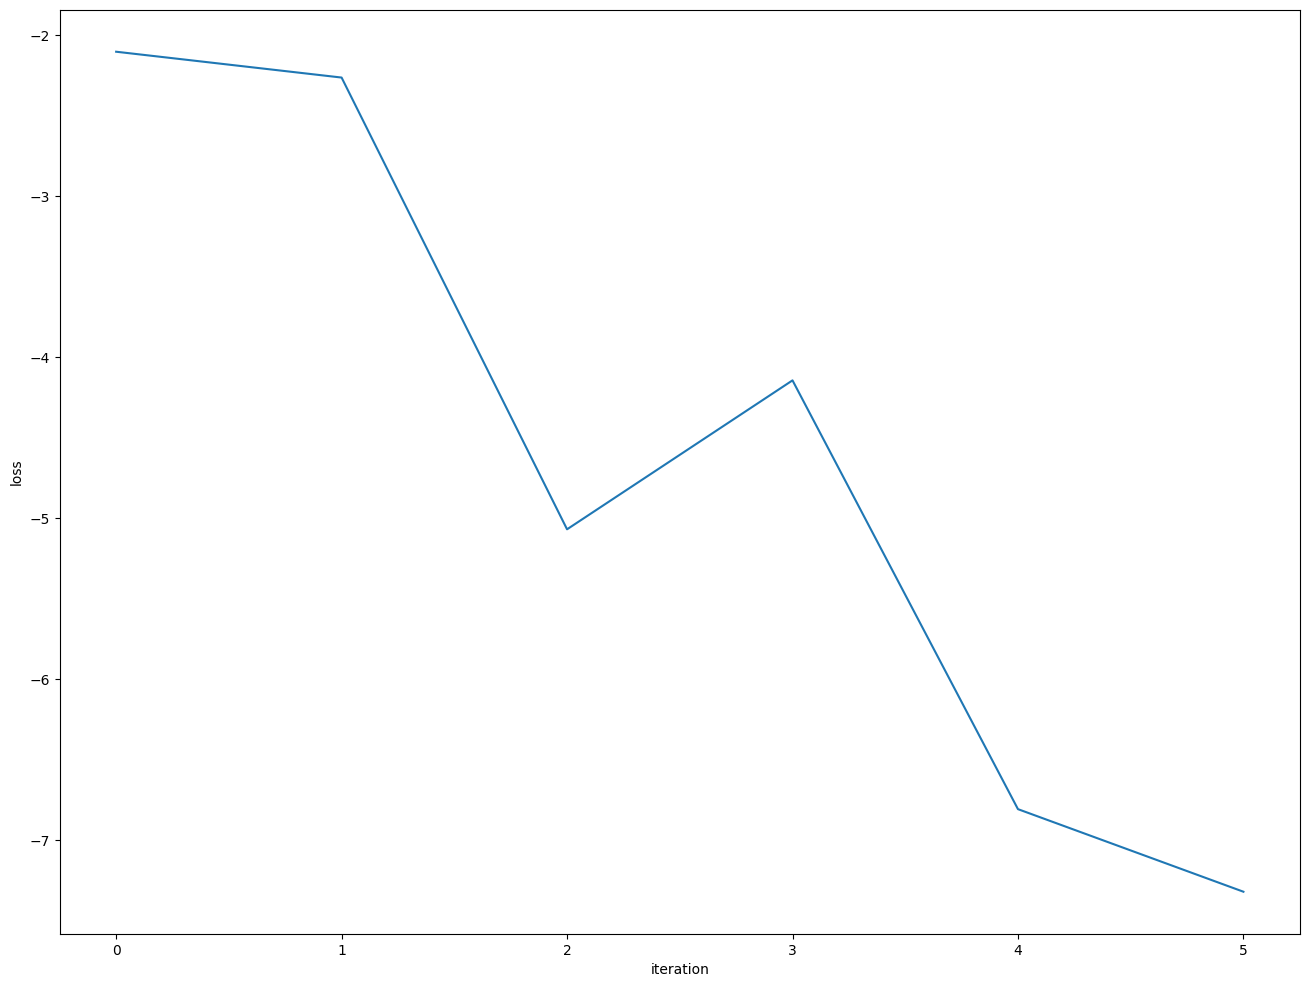

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

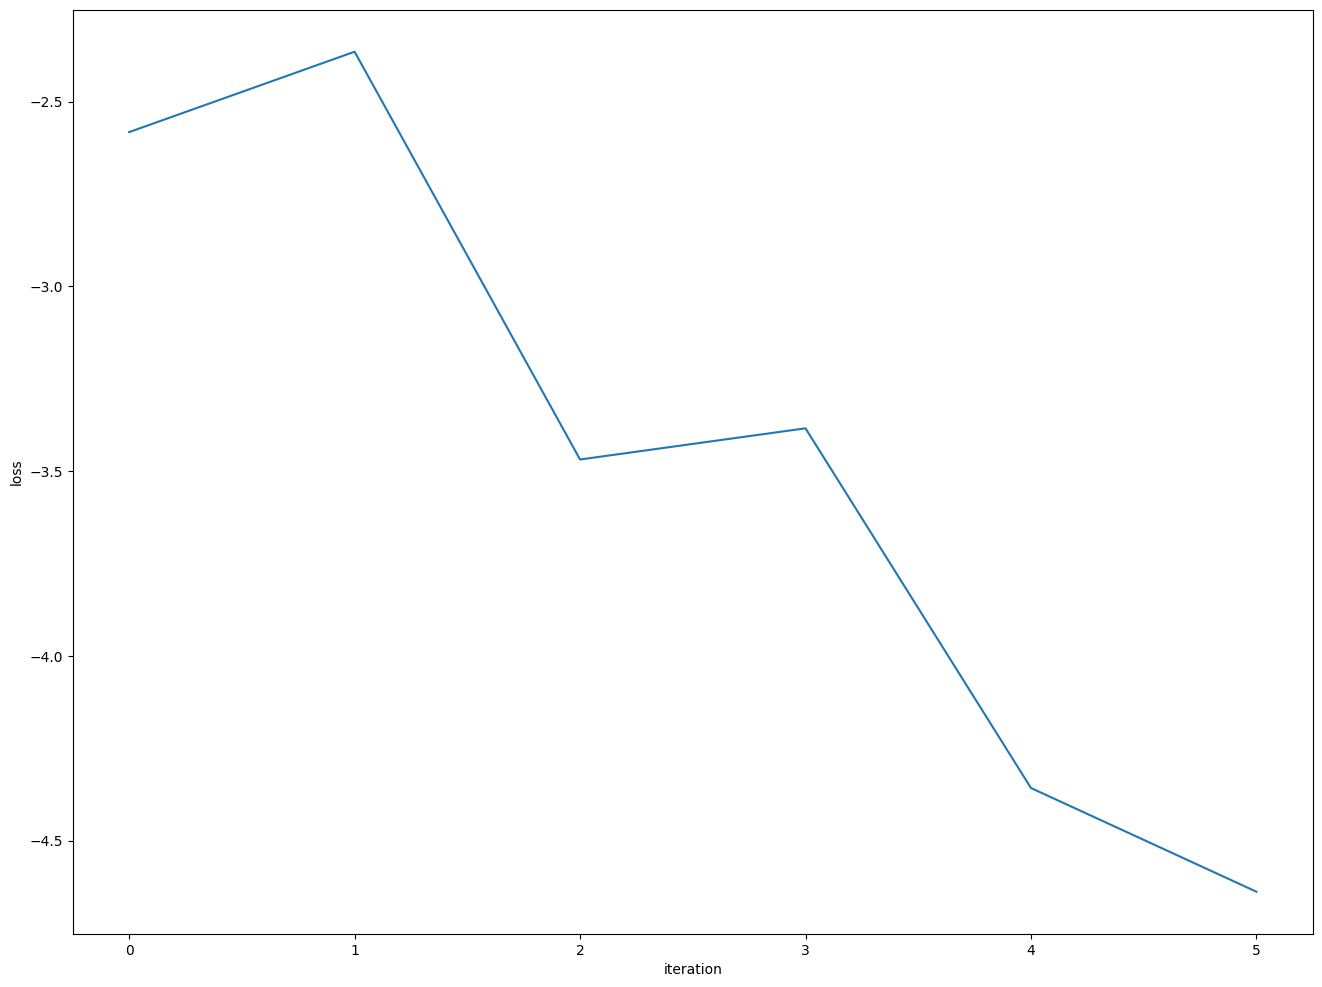

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")